<a href="https://colab.research.google.com/github/vitorbdiniz/Jensens-Alpha/blob/main/Jensen's_Alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##CAPM and Risk Factors

According to Sharpe (1964), Lintner (1962) and Treynor (1965), the expected return of a given portfolio is linearly dependent on its risk-premium:

> **E(R p,t ) − R f,t = β[E(R m,t ) − R f,t ]**

Where:


1.   **E(R m,t ) − R f,t** is the market risk premium factor
2.   **R f,t** is a risk-free rate


This equation is called **Capital Asset Pricing Model (CAPM)**.

Furthermore, Jensen(1964) verified that there is a persistent error in the CAPM. In simple terms, good portfolios managers used to keep this error positive and not so good managers used to mantain it on zero or even negative. Thus he alterated the above equation, introducing a new element: the alpha (also called Jensen's Alpha):

> **E(R c,t ) − R f,t = α + β1[E(R m,t ) − R f,t ] + e** 

Where:
1. **α** means the Jensen's alpha
2. **e** means the regression error


Jensen's Alpha is still used to measure the portfolio manager's skills.

Years later, Fama and French (1993) added 2 more factors to the CAPM: value and size factor. And, finally, Liu (2006) added liquidity and momentum risk factors, converging into the following equation:

> **E(R c,t ) − R f,t = α + β1[E(R m,t ) − R f,t ] + β2(SMB) t + β3(HML) t + β4(MOM ) t + β5(LIQ) t + *e* **

Where:



1.   **SMB** means the size factor
2.   **HML** means the value factor
3.   **MOM** means the momentum factor
4.   **LIQ** means the liquidity factor
5.   ***e*** means the regression error

**In this report I am going to analyse some of my favorite brazilian investiment funds' Jensen's Alpha from their beginning until December 31st 2020.**

#Disclaimer

- **Nothing in this report consists of an indication to buy or sell any assets;**

- **Everything in this report consists simply of a study of the performance data of investment funds chosen by an affinity between me and their managers.**

# Calculating Jensen's Alpha

##Preparing Code

###importing libraries

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Auxiliary Functions

In [ ]:
def outliers_number(original_df, treated_df = None):
    """
        Count the number of outlier rows in a pandas dataframe

        returns the number of outliers (int)
    """
    if treated_df == None:
        treated_df = outlier_treatment(original_df, quantile=0.25, mult=1.5)
    return original_df.shape[0] - treated_df.shape[0]


def outlier_treatment(data, quantile=0.25, mult=1.5):
    """
        Identify and withdraw outliers using the inter quantile range method.

        returns dataframe without outliers
    """
    cols = data.columns.tolist()
    outliers = set()
    for fac in cols:
        q75 = np.quantile([ float(x) for x in data[fac]], 1-quantile)
        q25 = np.quantile([ float(x) for x in data[fac]], quantile)
        iqr = q75 - q25
        upper, lower = q75 + iqr*mult , q25 - iqr*mult
        for i in data.index:
            num = data[fac].loc[i].iloc[-1] if type(data[fac].loc[i]) == type(pd.Series(dtype=np.float64)) else data[fac].loc[i]
            if num > upper or num < lower:
                outliers.add(i)
    result = data.drop(outliers, axis="rows")
    return result

In [ ]:
datetime_to_date_list = lambda array : [x.date() for x in array] #convert a list of datetimes into a list of dates
string_to_date_list = lambda array : [dt.date(year=int(x[0:4]), month=int(x[5:7]), day=int(x[8:10])) for x in array] #convert a list of strings into a list of dates
string_to_date_list_of_lists = lambda list_of_lists : [string_to_date_list(x) for x in list_of_lists] #convert a list of lists of strings into a list of lists of dates
concat_date = lambda date : [dt.date(date[0].iloc[i], date[1].iloc[i], date[2].iloc[i]) for i in range(len(date[0]))]#convert a list of years, months and dates into a list of dates

##Risk Factors

Source: [Brazilian Center for Research in Financial Economics of the University of São Paulo](http://nefin.com.br/principal.html)

In [ ]:
mkt = pd.read_excel("http://nefin.com.br/Risk%20Factors/Market_Factor.xls") #Market factor
hml = pd.read_excel("http://nefin.com.br/Risk%20Factors/HML_Factor.xls")    #Value factor
smb = pd.read_excel("http://nefin.com.br/Risk%20Factors/SMB_Factor.xls")    #Size factor
wml = pd.read_excel("http://nefin.com.br/Risk%20Factors/WML_Factor.xls")    #Momentum factor
iml = pd.read_excel("http://nefin.com.br/Risk%20Factors/IML_Factor.xls")    #Liquidity factor

risk_factors = pd.DataFrame({"year":mkt["year"], "month":mkt["month"], "day":mkt["day"], 
                             "MKT" : mkt["Rm_minus_Rf"], 
                             "HML" : hml["HML"], 
                             "SMB" : smb["SMB"],
                             "WML" : wml["WML"],
                             "IML" : iml["IML"]
                             })
risk_factors.tail(5)

,year,month,day,MKT,HML,SMB,WML,IML
4964,2021,1,22,-0.009704,0.000523,-0.006062,0.004737,-0.003698
4965,2021,1,26,-0.009102,-0.012009,-0.002526,-0.000980,0.002481
4966,2021,1,27,-0.005954,0.010859,0.004380,-0.020807,-0.002368
4967,2021,1,28,0.023221,0.003190,0.003113,-0.018209,-0.000233
4968,2021,1,29,-0.029990,0.001977,0.011734,0.001494,0.012278


In [ ]:
risk_factors.index = concat_date([risk_factors["year"], risk_factors["month"], risk_factors['day']])
risk_factors.drop(columns=["year", "month", "day"], inplace=True)
risk_factors = risk_factors.iloc[0: risk_factors.index.get_loc(dt.date(2020,12,31), method="pad",tolerance=dt.timedelta(days=1))]

In [ ]:
risk_factors.tail(5)

,MKT,HML,SMB,WML,IML
2020-12-21,-0.017814,0.000637,-0.001355,0.011563,-0.000735
2020-12-22,0.005462,-0.011581,-0.018286,0.017957,-0.016714
2020-12-23,0.009485,0.007392,0.002756,-0.006470,0.001534
2020-12-28,0.011460,-0.007080,-0.007147,0.000487,-0.004078
2020-12-29,0.002851,0.001345,0.006832,-0.000530,0.005666


###Checking Stationarity

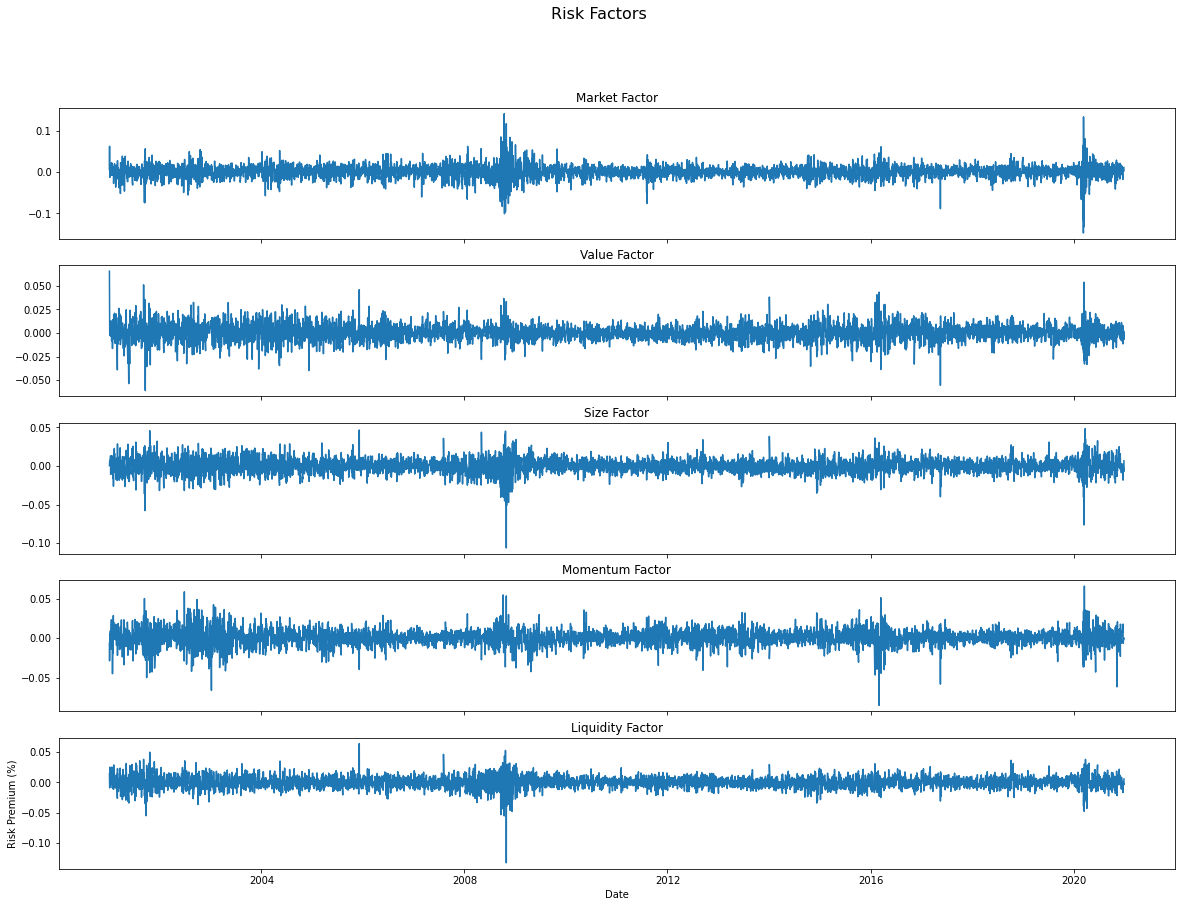

In [ ]:
fig, ax = plt.subplots(5,1,sharex=True,  figsize=(20,14))

fig.suptitle("Risk Factors", size=16)

plt.xlabel("Date")
plt.ylabel("Risk Premium (%)")

ax[0].plot(risk_factors["MKT"])
ax[0].set_title("Market Factor")

ax[1].plot(risk_factors["HML"])
ax[1].set_title("Value Factor")

ax[2].plot(risk_factors["SMB"])
ax[2].set_title("Size Factor")

ax[3].plot(risk_factors["WML"])
ax[3].set_title("Momentum Factor")

ax[4].plot(risk_factors["IML"])
ax[4].set_title("Liquidity Factor")

plt.show()

Even though the time series are mostly stationaries, we are able to identify some outliers in the graphics. Therefore, I will plot boxplots to verify those outliers.

###Verifying Outliers

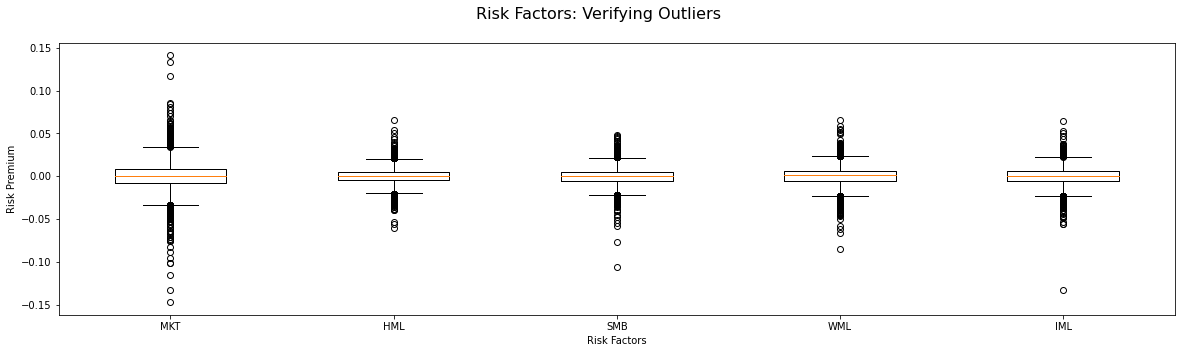

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
fig.suptitle("Risk Factors: Verifying Outliers", size=16)

ax.boxplot(x = [ risk_factors[x] for x in ["MKT", "HML", "SMB", "WML", "IML"] ], whis=1.5, labels=["MKT", "HML", "SMB", "WML", "IML"])
ax.set_ylabel("Risk Premium")
ax.set_xlabel("Risk Factors")

plt.show()

In [ ]:
number_of_outliers = outliers_number(risk_factors)
print(f"Number of outliers: {number_of_outliers}")
print(f"Percentage of outliers: {number_of_outliers/risk_factors.shape[0] *100:.2f}%")

Number of outliers: 559
Percentage of outliers: 11.30%


###Analysing Distribution

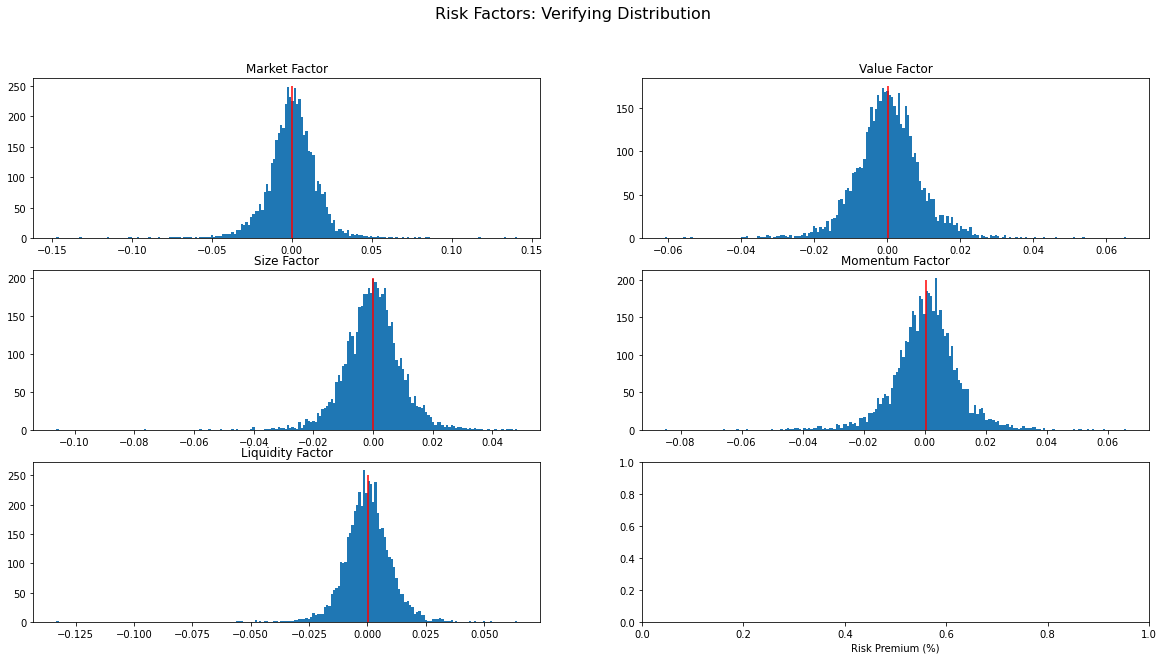

In [ ]:
fig, ax = plt.subplots(3,2,  figsize=(20,10))
fig.suptitle("Risk Factors: Verifying Distribution", size=16)
plt.xlabel("Risk Premium (%)")

ax[0,0].hist(risk_factors["MKT"], bins=200)
ax[0,0].vlines(x=risk_factors["MKT"].mean(), ymin=0, ymax=250, color="red")
ax[0,0].set_title("Market Factor")

ax[0,1].hist(risk_factors["HML"], bins=200)
ax[0,1].vlines(x=risk_factors["HML"].mean(), ymin=0, ymax=175, color="red")
ax[0,1].set_title("Value Factor")

ax[1,0].hist(risk_factors["SMB"], bins=200)
ax[1,0].vlines(x=risk_factors["SMB"].mean(), ymin=0, ymax=200, color="red")
ax[1,0].set_title("Size Factor")

ax[1,1].hist(risk_factors["WML"], bins=200)
ax[1,1].vlines(x=risk_factors["WML"].mean(), ymin=0, ymax=200, color="red")
ax[1,1].set_title("Momentum Factor")

ax[2,0].hist(risk_factors["IML"], bins=200)
ax[2,0].vlines(x=risk_factors["IML"].mean(), ymin=0, ymax=250, color="red")
ax[2,0].set_title("Liquidity Factor")

plt.show()

Except for the momentum factor, whose distribution is slightly inclinated to the right, all factors seem to have a normal distribution. Nevertheless, since there are 11% of outliers, they will be treated.

### Treating Outliers

In [ ]:
risk_factors_treated = outlier_treatment(risk_factors, quantile=0.25, mult=1.5) 
risk_factors_treated.tail(5)

,MKT,HML,SMB,WML,IML
2020-12-21,-0.017814,0.000637,-0.001355,0.011563,-0.000735
2020-12-22,0.005462,-0.011581,-0.018286,0.017957,-0.016714
2020-12-23,0.009485,0.007392,0.002756,-0.006470,0.001534
2020-12-28,0.011460,-0.007080,-0.007147,0.000487,-0.004078
2020-12-29,0.002851,0.001345,0.006832,-0.000530,0.005666


#### Checking treated time series stationarity, outliers and distribution

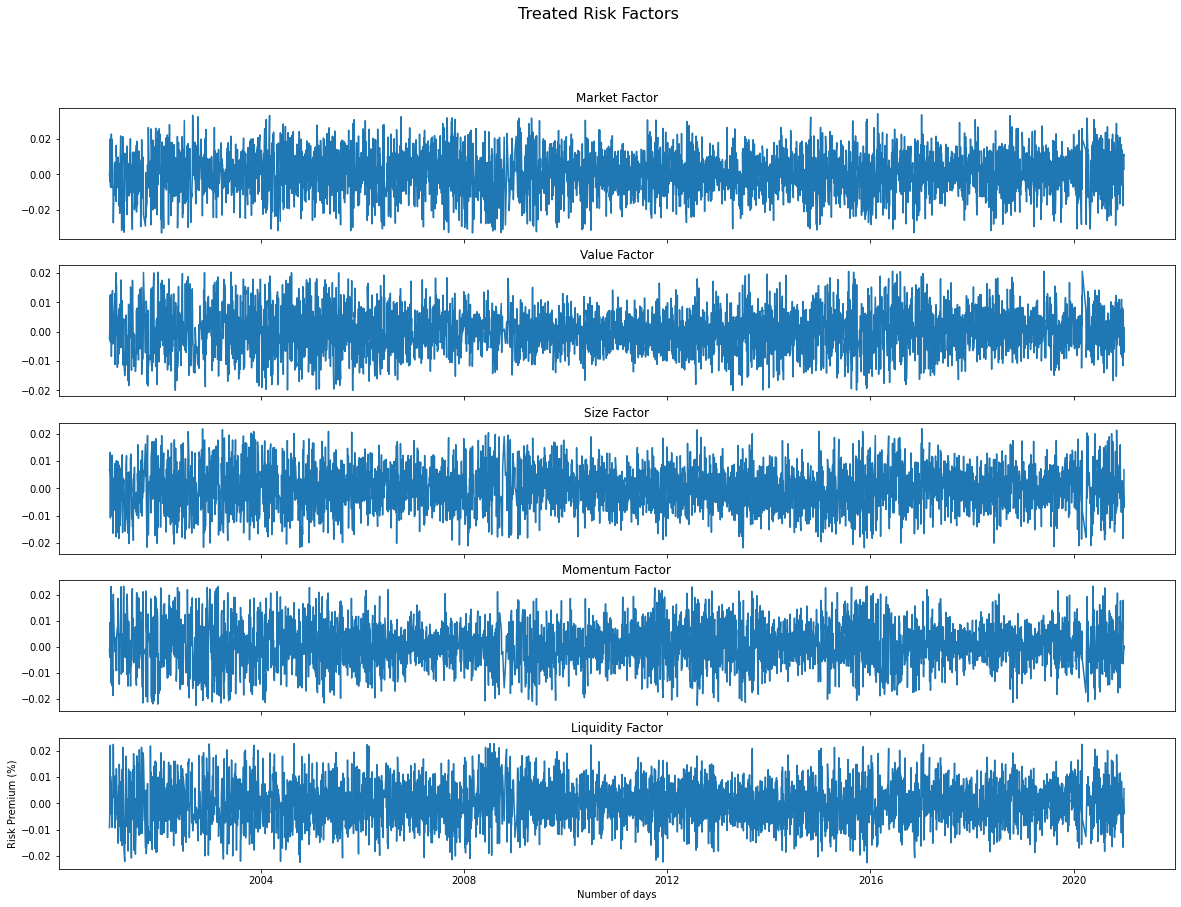

In [ ]:
fig, ax = plt.subplots(5,1,sharex=True,  figsize=(20,14))

fig.suptitle("Treated Risk Factors", size=16)

plt.xlabel("Number of days")
plt.ylabel("Risk Premium (%)")

ax[0].set_title("Market Factor")
ax[0].plot(risk_factors_treated["MKT"], zorder=0, label="Market Factor Values")

ax[1].plot(risk_factors_treated["HML"], zorder=0, label="Value Factor Values")
ax[1].set_title("Value Factor")

ax[2].plot(risk_factors_treated["SMB"], zorder=0, label="Size Factor Values")
ax[2].set_title("Size Factor")

ax[3].plot(risk_factors_treated["WML"], zorder=0, label="Momentum Factor Values")
ax[3].set_title("Momentum Factor")

ax[4].plot(risk_factors_treated["IML"], zorder=0, label="Liquidity Factor Values")
ax[4].set_title("Liquidity Factor")

plt.show()

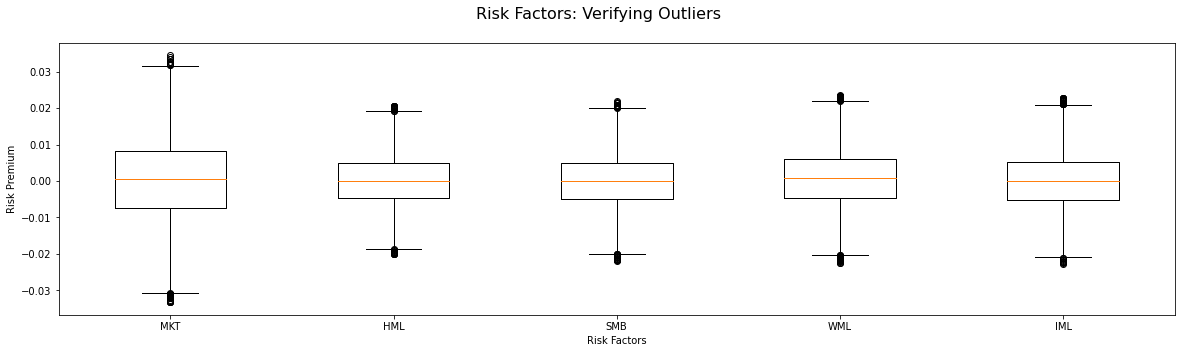

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
fig.suptitle("Risk Factors: Verifying Outliers", size=16)

ax.boxplot(x = [ risk_factors_treated[x] for x in ["MKT", "HML", "SMB", "WML", "IML"] ], whis=1.5, labels=["MKT", "HML", "SMB", "WML", "IML"], )
ax.set_ylabel("Risk Premium")
ax.set_xlabel("Risk Factors")

plt.show()

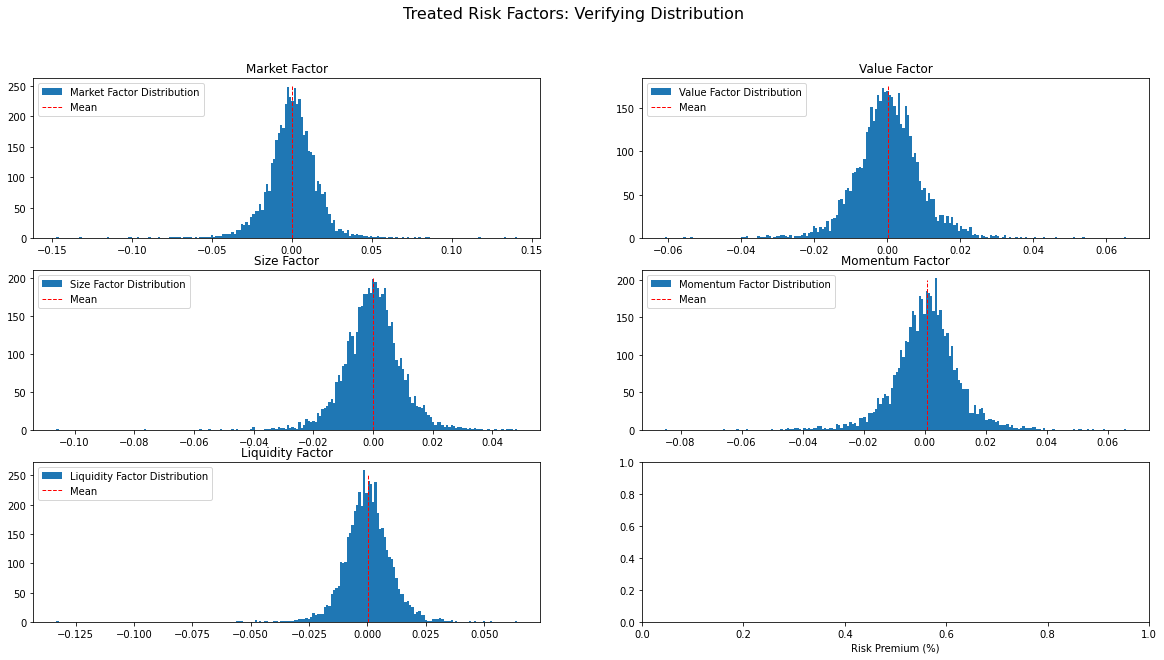

In [ ]:
fig, ax = plt.subplots(3,2,  figsize=(20,10))
fig.suptitle("Treated Risk Factors: Verifying Distribution", size=16)
plt.xlabel("Risk Premium (%)")

ax[0,0].hist(risk_factors["MKT"], bins=200, label="Market Factor Distribution")
ax[0,0].vlines(x=risk_factors_treated["MKT"].mean(), ymin=0, ymax=250, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[0,0].set_title("Market Factor")
ax[0,0].legend(loc=2)

ax[0,1].hist(risk_factors["HML"], bins=200, label="Value Factor Distribution")
ax[0,1].vlines(x=risk_factors_treated["HML"].mean(), ymin=0, ymax=175, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[0,1].set_title("Value Factor")
ax[0,1].legend(loc=2)

ax[1,0].hist(risk_factors["SMB"], bins=200, label="Size Factor Distribution")
ax[1,0].vlines(x=risk_factors_treated["SMB"].mean(), ymin=0, ymax=200, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[1,0].set_title("Size Factor")
ax[1,0].legend(loc=2)

ax[1,1].hist(risk_factors["WML"], bins=200, label="Momentum Factor Distribution")
ax[1,1].vlines(x=risk_factors_treated["WML"].mean(), ymin=0, ymax=200, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[1,1].set_title("Momentum Factor")
ax[1,1].legend(loc=2)

ax[2,0].hist(risk_factors["IML"], bins=200, label="Liquidity Factor Distribution")
ax[2,0].vlines(x=risk_factors_treated["IML"].mean(), ymin=0, ymax=250, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[2,0].set_title("Liquidity Factor")
ax[2,0].legend(loc=2)

plt.show()

Now the factors are ready to be used as dependent variables on the 5-factor CAPM model.

##Funds Performances

The next step is to search for some brazilian funds returns to apply the model and evaluate their alpha.

Funds evaluated:
1.   [Alaska Black](https://www.alaska-asset.com.br/fundos/)
2.   [AvantGarde](https://www.avantgardeam.com.br/)
3.   [Constellation](https://constellation.com.br/)
4.   [Cosmos](https://tc.com.br/store/cursos/metodo-cosmos)
5.   [Dynamo Cougar](https://www.dynamo.com.br/pt)
6.   [Real Investor](https://www.realinvestor.com.br/)
7.   [Verde](https://verdeasset.com.br)




Source: [InfoFundos](https://www.infofundos.com)


In [ ]:
verde         = pd.read_csv("/content/drive/My Drive/performances/verde.csv", index_col=0)[["variacao"]]
alaska        = pd.read_csv("/content/drive/My Drive/performances/alaska.csv", index_col=0)[["variacao"]]
avantgarde    = pd.read_csv("/content/drive/My Drive/performances/avantgarde.csv", index_col=0)[["variacao"]]
constellation = pd.read_csv("/content/drive/My Drive/performances/constellation.csv", index_col=0)[["variacao"]]
cosmos        = pd.read_csv("/content/drive/My Drive/performances/cosmos.csv", index_col=0)[["variacao"]]
dynamo        = pd.read_csv("/content/drive/My Drive/performances/dynamo.csv", index_col=0)[["variacao"]]
real          = pd.read_csv("/content/drive/My Drive/performances/real_investor.csv", index_col=0)[["variacao"]]

for p in [verde,alaska,avantgarde,constellation,cosmos,dynamo,real ]:
    p.dropna(inplace=True)

####Date adjustments

In [ ]:
indexes = [alaska.index, avantgarde.index, constellation.index, cosmos.index, dynamo.index, real.index, verde.index]
(alaska.index, avantgarde.index, constellation.index, cosmos.index, dynamo.index, real.index, verde.index) = string_to_date_list_of_lists(indexes)



Now that we have dates as indexes in all dataframes, let's proceed with an exploratory analysis on funds' data.

###Checking Stationarity

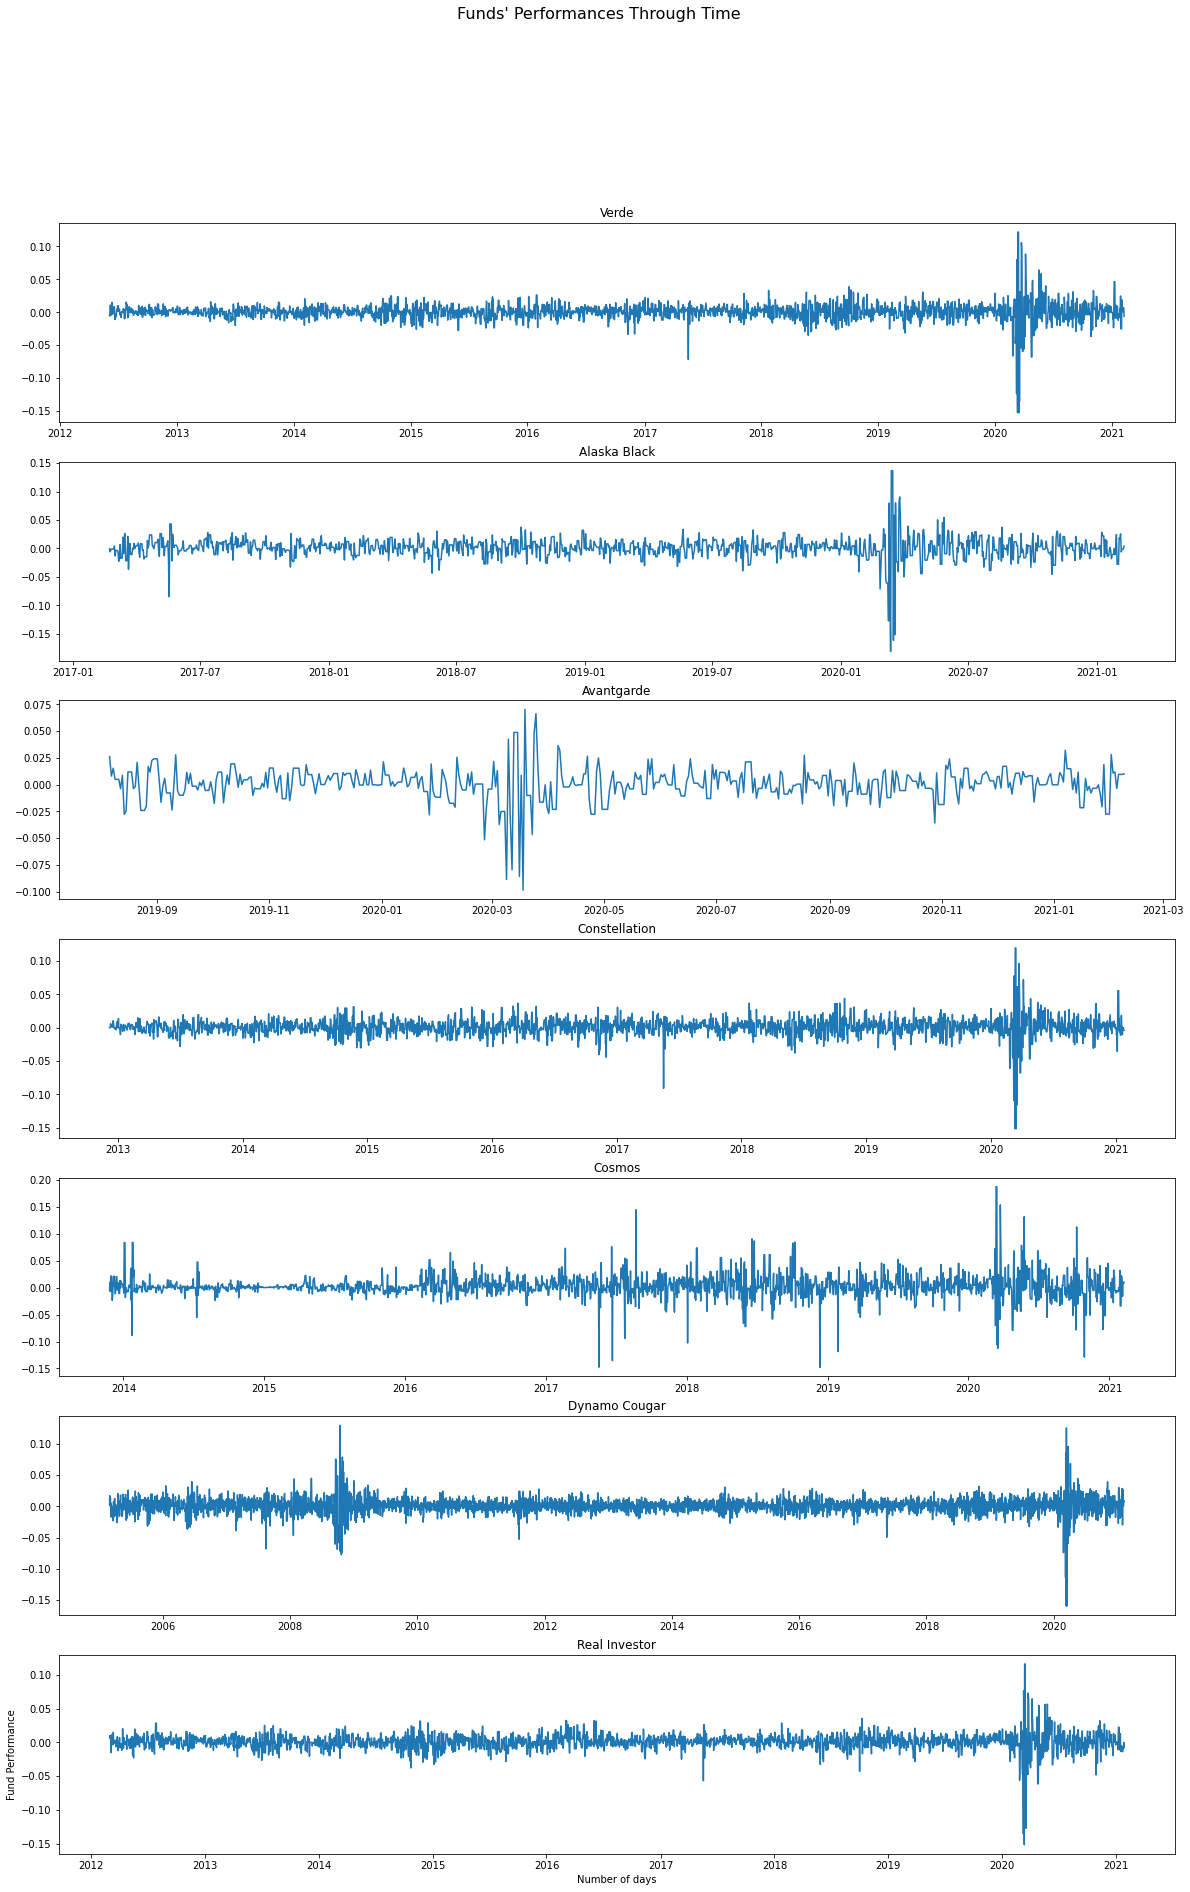

In [ ]:
fig, ax = plt.subplots(7,1,  figsize=(20,30))

fig.suptitle("Funds' Performances Through Time", size=16)

plt.xlabel("Number of days")
plt.ylabel("Fund Performance")

ax[0].plot(verde)
ax[0].set_title("Verde")

ax[1].plot(alaska)
ax[1].set_title("Alaska Black")

ax[2].plot(avantgarde)
ax[2].set_title("Avantgarde")

ax[3].plot(constellation)
ax[3].set_title("Constellation")

ax[4].plot(cosmos)
ax[4].set_title("Cosmos")

ax[5].plot(dynamo)
ax[5].set_title("Dynamo Cougar")

ax[6].plot(real)
ax[6].set_title("Real Investor")

plt.show()

Naturally, in moments of crisis (such as subprime crisis and covid-19 crisis) volatility increases and generates some outliers, as we can see in the next section.

###Verifying Outliers

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


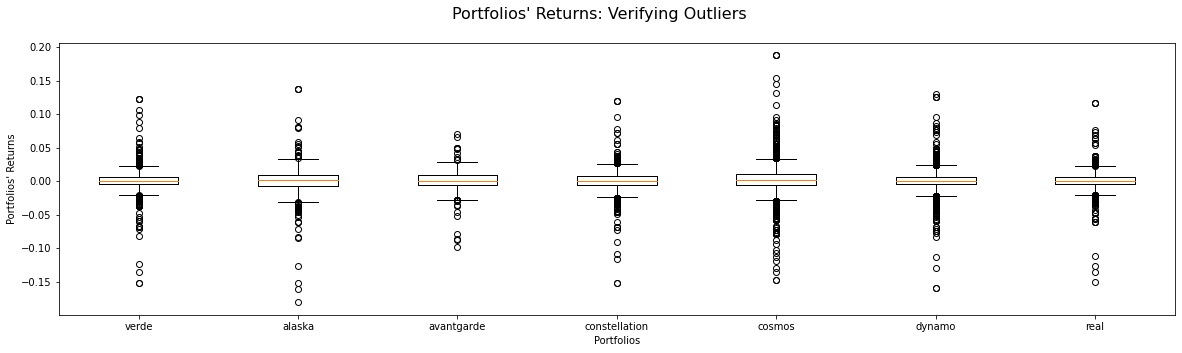

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
fig.suptitle("Portfolios' Returns: Verifying Outliers", size=16)

ax.boxplot(x = [verde,alaska,avantgarde,constellation,cosmos,dynamo,real ], whis=1.5, labels=["verde","alaska","avantgarde","constellation","cosmos","dynamo","real"])
ax.set_ylabel("Portfolios' Returns")
ax.set_xlabel("Portfolios")

plt.show()

In [ ]:
portfolios = {"verde":verde,"alaska":alaska,"avantgarde":avantgarde,"constellation":constellation,"cosmos":cosmos,"dynamo":dynamo,"real":real}
for portfolio in portfolios:
    number_of_outliers = outliers_number(portfolios[portfolio])
    print(str(portfolio).upper())
    print(f"Number of outliers: {number_of_outliers}")
    print(f"Percentage of outliers: {number_of_outliers/portfolios[portfolio].shape[0] *100:.2f}%")
    print("-------------------------------------")

VERDE
Number of outliers: 156
Percentage of outliers: 4.92%
-------------------------------------
ALASKA
Number of outliers: 49
Percentage of outliers: 3.38%
-------------------------------------
AVANTGARDE
Number of outliers: 24
Percentage of outliers: 4.34%
-------------------------------------
CONSTELLATION
Number of outliers: 139
Percentage of outliers: 4.68%
-------------------------------------
COSMOS
Number of outliers: 266
Percentage of outliers: 10.11%
-------------------------------------
DYNAMO
Number of outliers: 250
Percentage of outliers: 4.29%
-------------------------------------
REAL
Number of outliers: 168
Percentage of outliers: 5.16%
-------------------------------------


###Analysing Distribution

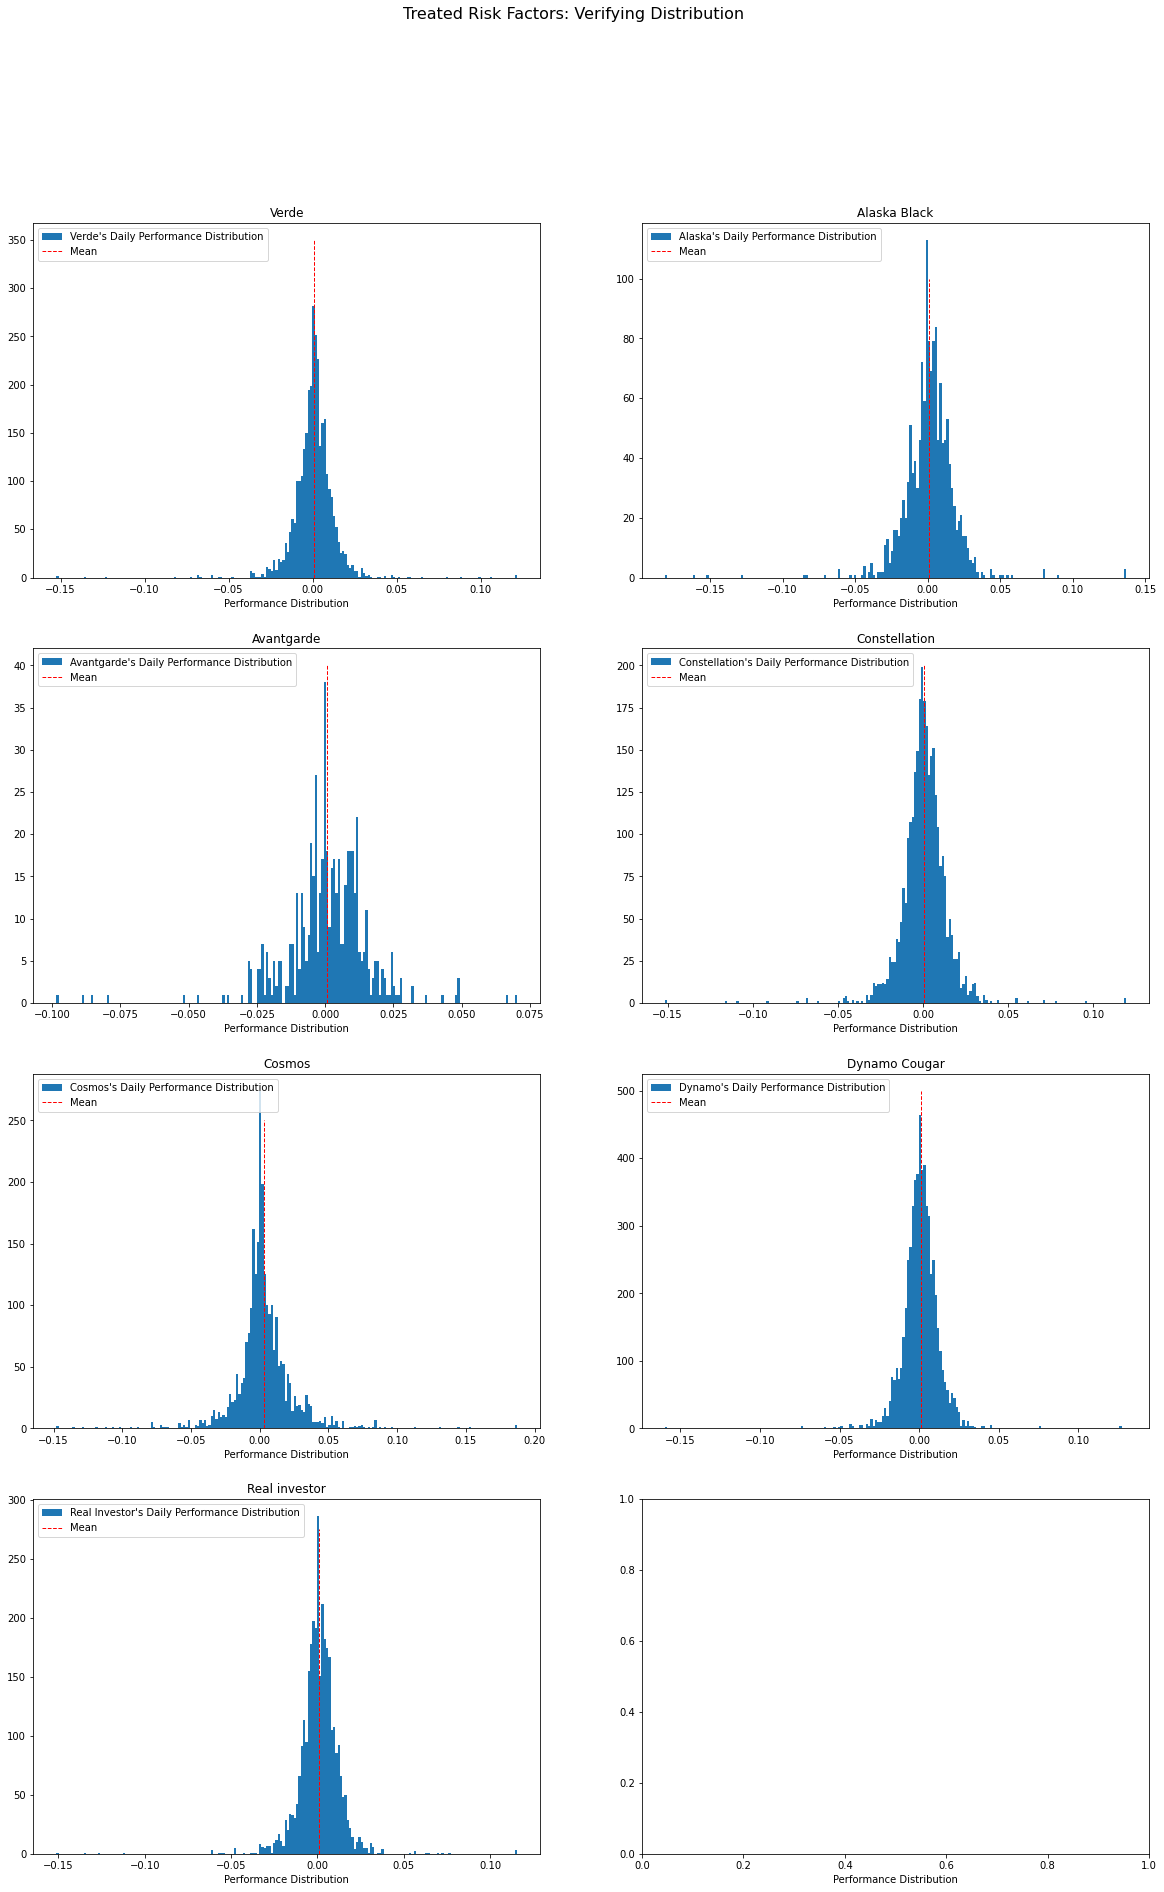

In [ ]:
fig, ax = plt.subplots(4,2,  figsize=(20,30))
fig.suptitle("Treated Risk Factors: Verifying Distribution", size=16)


ax[0,0].hist(verde["variacao"], bins=200, label="Verde's Daily Performance Distribution")
ax[0,0].vlines(x=verde["variacao"].mean(), ymin=0, ymax=350, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[0,0].set_title("Verde")
ax[0,0].legend(loc=2)

ax[0,1].hist(alaska["variacao"], bins=200, label="Alaska's Daily Performance Distribution")
ax[0,1].vlines(x=alaska["variacao"].mean(), ymin=0, ymax=100, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[0,1].set_title("Alaska Black")
ax[0,1].legend(loc=2)

ax[1,0].hist(avantgarde["variacao"], bins=200, label="Avantgarde's Daily Performance Distribution")
ax[1,0].vlines(x=avantgarde["variacao"].mean(), ymin=0, ymax=40, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[1,0].set_title("Avantgarde")
ax[1,0].legend(loc=2)

ax[1,1].hist(constellation["variacao"], bins=200, label="Constellation's Daily Performance Distribution")
ax[1,1].vlines(x=constellation["variacao"].mean(), ymin=0, ymax=200, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[1,1].set_title("Constellation")
ax[1,1].legend(loc=2)

ax[2,0].hist(cosmos["variacao"], bins=200, label="Cosmos's Daily Performance Distribution")
ax[2,0].vlines(x=cosmos["variacao"].mean(), ymin=0, ymax=250, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[2,0].set_title("Cosmos")
ax[2,0].legend(loc=2)

ax[2,1].hist(dynamo["variacao"], bins=200, label="Dynamo's Daily Performance Distribution")
ax[2,1].vlines(x=dynamo["variacao"].mean(), ymin=0, ymax=500, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[2,1].set_title("Dynamo Cougar")
ax[2,1].legend(loc=2)

ax[3,0].hist(real["variacao"], bins=200, label="Real Investor's Daily Performance Distribution")
ax[3,0].vlines(x=real["variacao"].mean(), ymin=0, ymax=275, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[3,0].set_title("Real investor")
ax[3,0].legend(loc=2)


for i in range(4):
    for j in range(2):
        ax[i,j].set_xlabel("Performance Distribution")


plt.show()

Therefore, for optimizing the model's power of generalization, outliers should be removed.

###Removing outliers

In [ ]:
verde_treated         = outlier_treatment(verde, quantile=0.25, mult=1.5)
alaska_treated        = outlier_treatment(alaska, quantile=0.25, mult=1.5)
avantgarde_treated    = outlier_treatment(avantgarde, quantile=0.25, mult=1.5)
constellation_treated = outlier_treatment(constellation, quantile=0.25, mult=1.5)
cosmos_treated        = outlier_treatment(cosmos, quantile=0.25, mult=1.5)
dynamo_treated        = outlier_treatment(dynamo, quantile=0.25, mult=1.5)
real_treated          = outlier_treatment(real, quantile=0.25, mult=1.5)

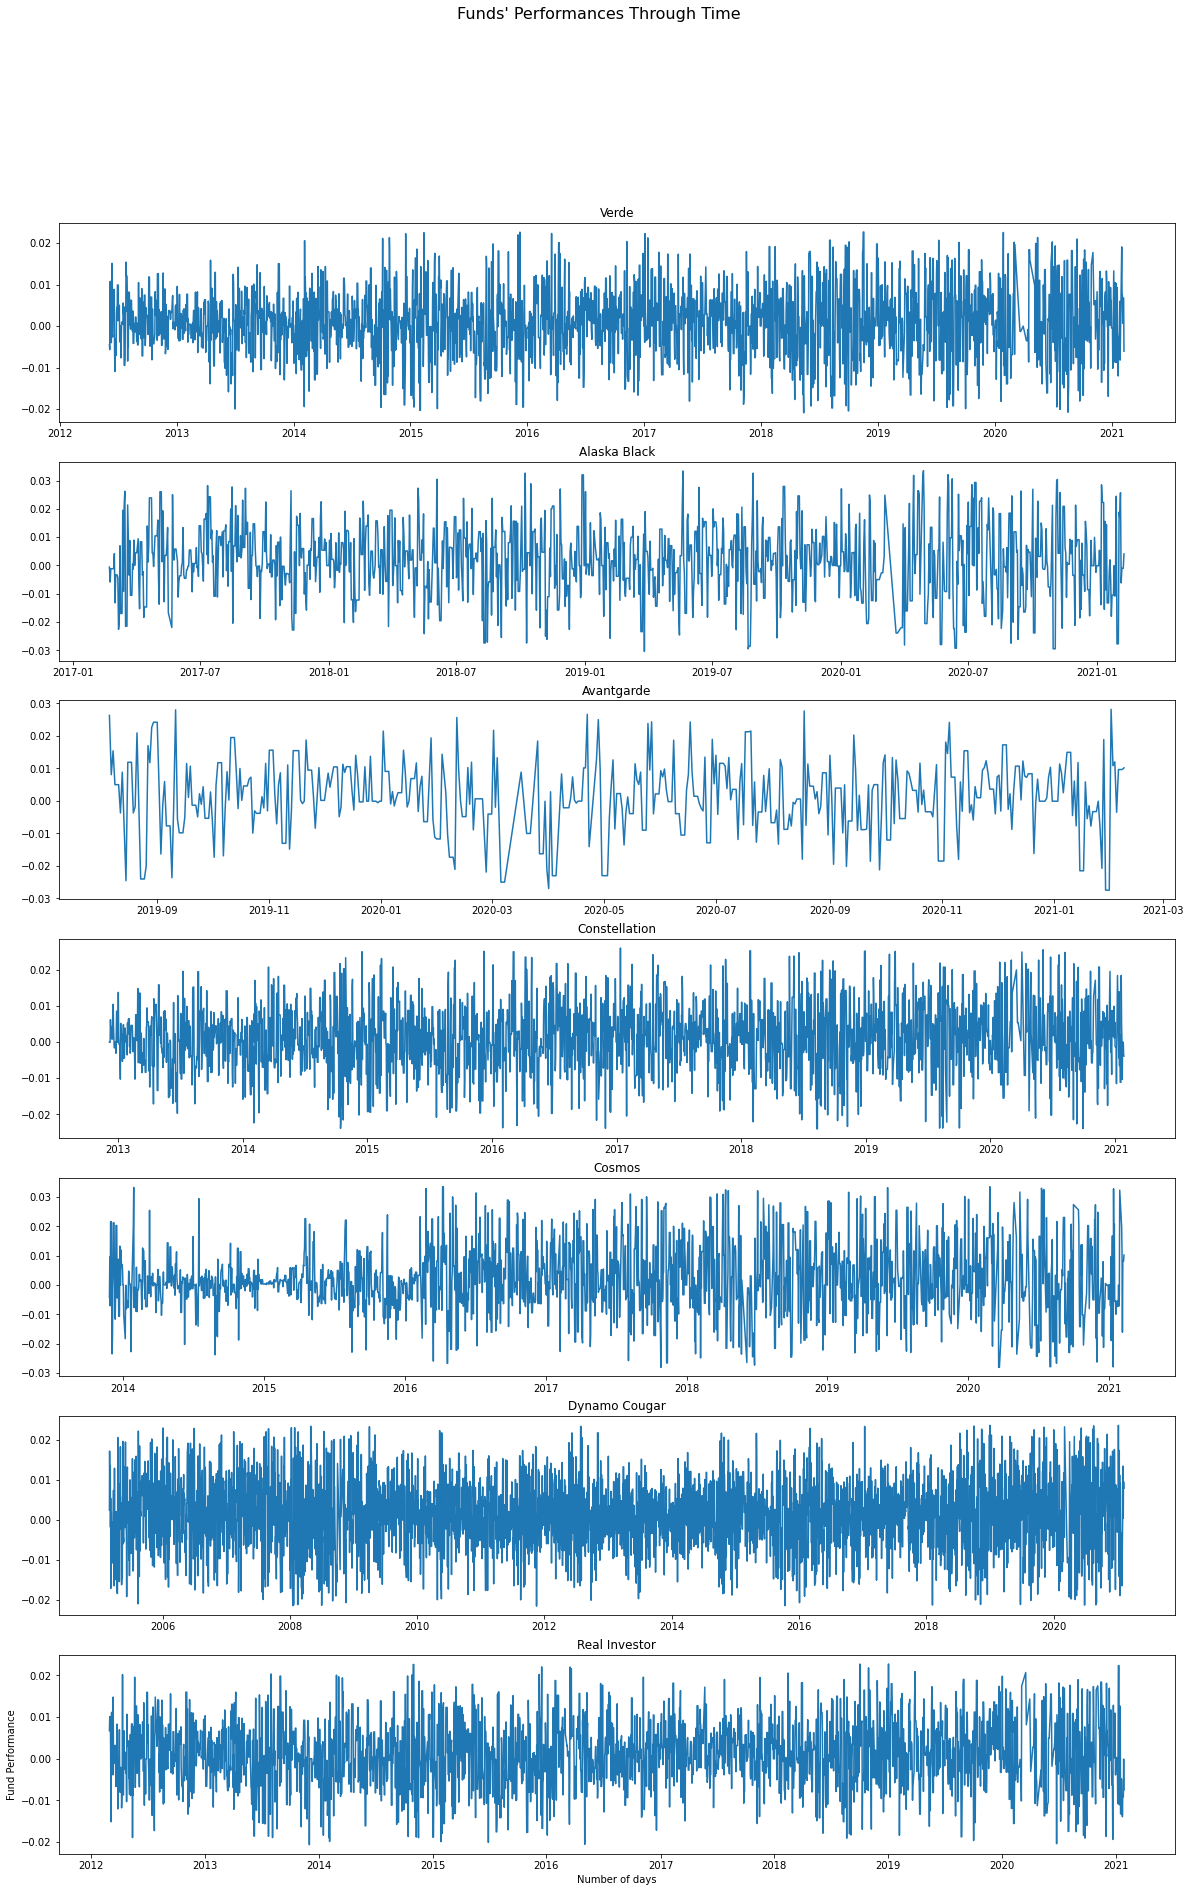

In [ ]:
fig, ax = plt.subplots(7,1,  figsize=(20,30))

fig.suptitle("Funds' Performances Through Time", size=16)

plt.xlabel("Number of days")
plt.ylabel("Fund Performance")

ax[0].plot(verde_treated)
ax[0].set_title("Verde")

ax[1].plot(alaska_treated)
ax[1].set_title("Alaska Black")

ax[2].plot(avantgarde_treated)
ax[2].set_title("Avantgarde")

ax[3].plot(constellation_treated)
ax[3].set_title("Constellation")

ax[4].plot(cosmos_treated)
ax[4].set_title("Cosmos")

ax[5].plot(dynamo_treated)
ax[5].set_title("Dynamo Cougar")

ax[6].plot(real_treated)
ax[6].set_title("Real Investor")

plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


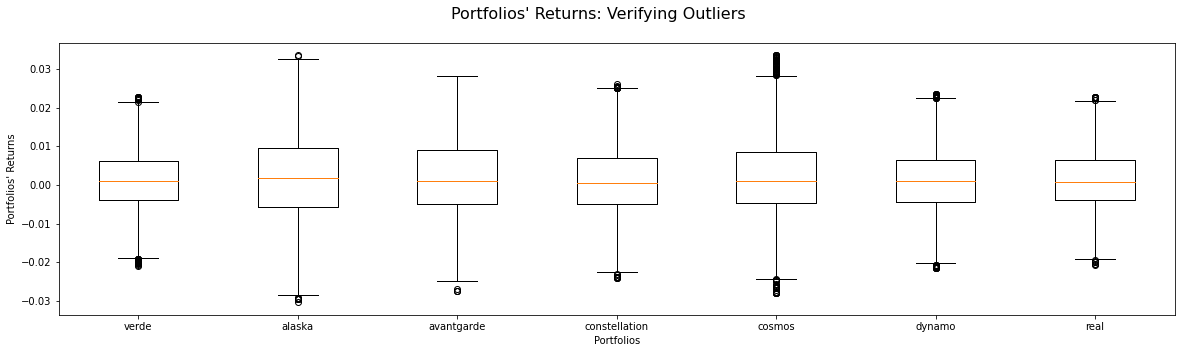

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
fig.suptitle("Portfolios' Returns: Verifying Outliers", size=16)

ax.boxplot(x = [ verde_treated,alaska_treated,avantgarde_treated,constellation_treated,cosmos_treated,dynamo_treated,real_treated ], whis=1.5, labels=["verde","alaska","avantgarde","constellation","cosmos","dynamo","real"])
ax.set_ylabel("Portfolios' Returns")
ax.set_xlabel("Portfolios")

plt.show()

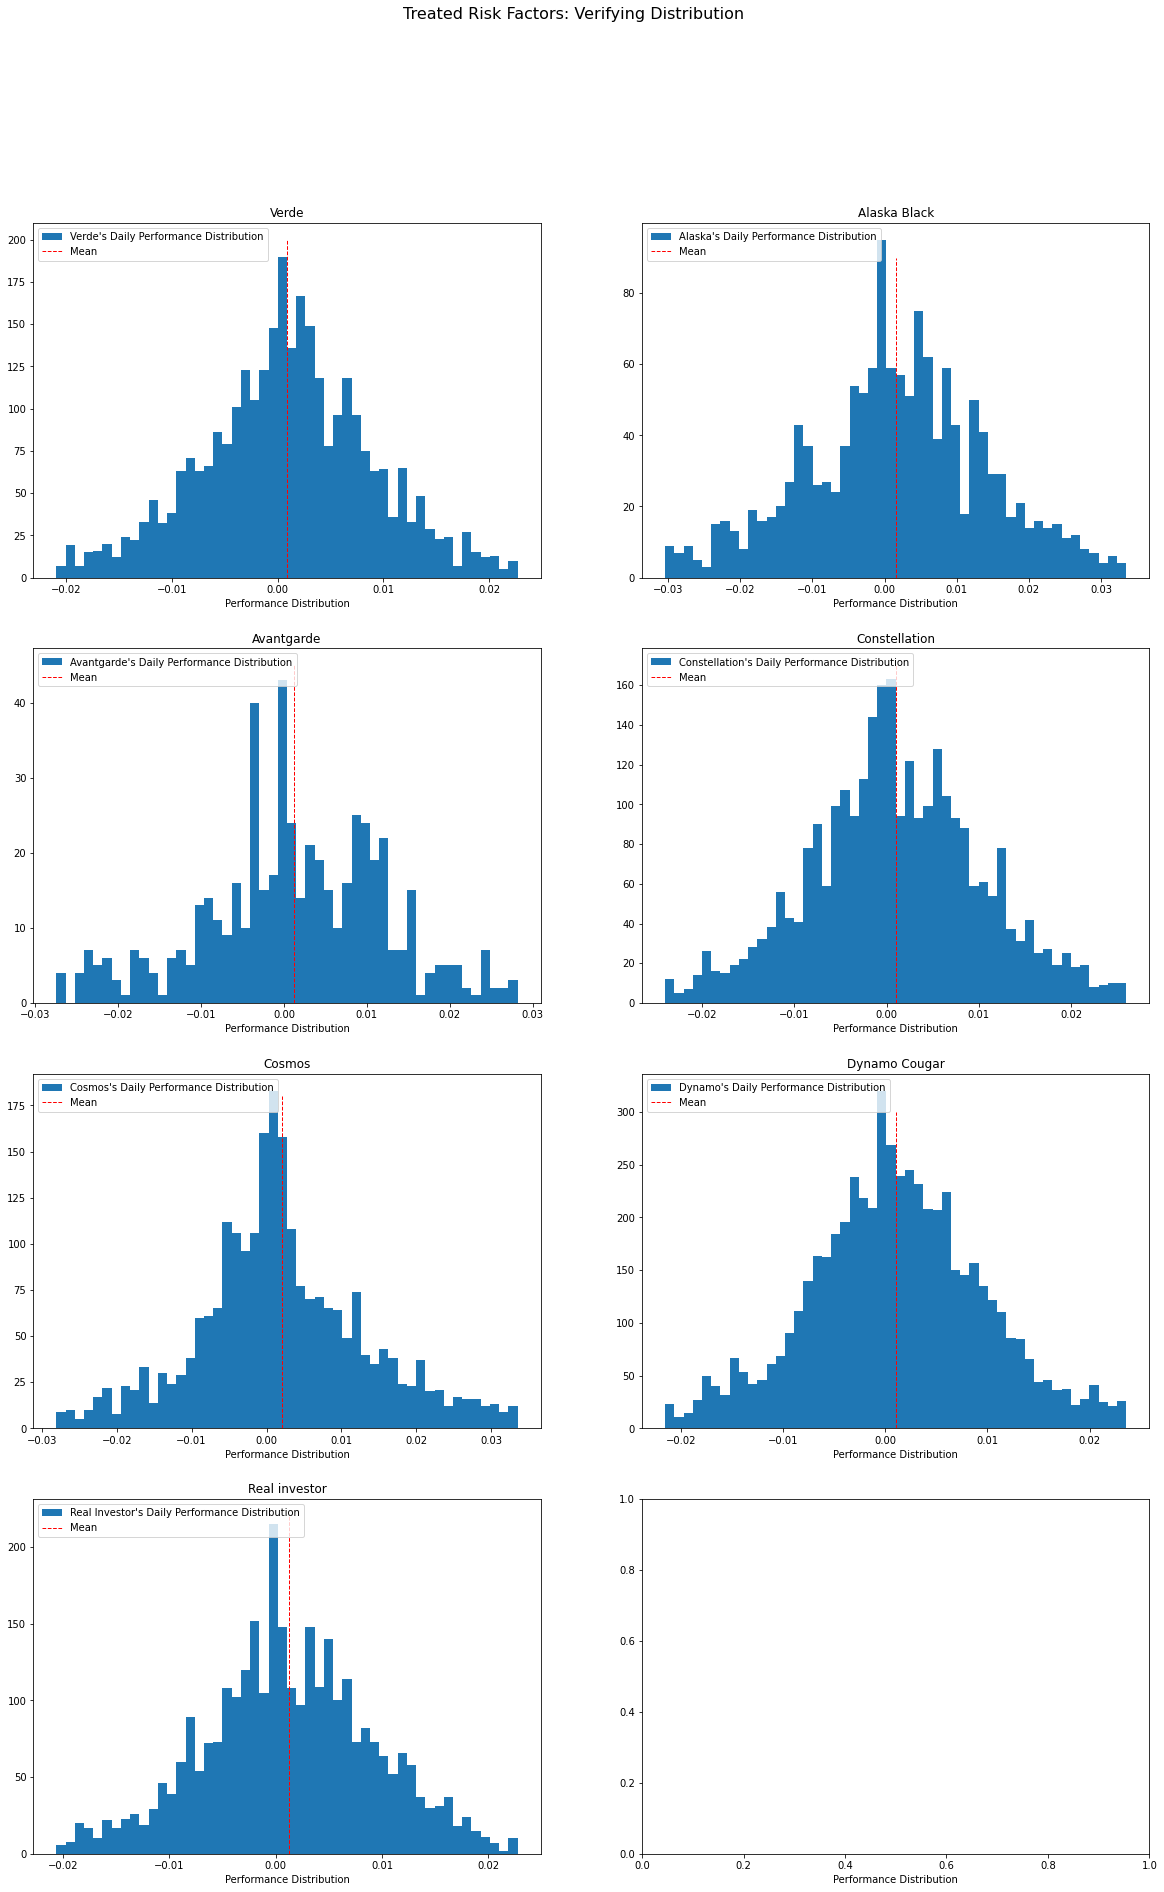

In [ ]:
fig, ax = plt.subplots(4,2,  figsize=(20,30))
fig.suptitle("Treated Risk Factors: Verifying Distribution", size=16)

bins = 50

ax[0,0].hist(verde_treated["variacao"], bins=bins, label="Verde's Daily Performance Distribution")
ax[0,0].vlines(x=verde_treated["variacao"].mean(), ymin=0, ymax=200, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[0,0].set_title("Verde")
ax[0,0].legend(loc=2)

ax[0,1].hist(alaska_treated["variacao"], bins=bins, label="Alaska's Daily Performance Distribution")
ax[0,1].vlines(x=alaska_treated["variacao"].mean(), ymin=0, ymax=90, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[0,1].set_title("Alaska Black")
ax[0,1].legend(loc=2)

ax[1,0].hist(avantgarde_treated["variacao"], bins=bins, label="Avantgarde's Daily Performance Distribution")
ax[1,0].vlines(x=avantgarde_treated["variacao"].mean(), ymin=0, ymax=45, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[1,0].set_title("Avantgarde")
ax[1,0].legend(loc=2)

ax[1,1].hist(constellation_treated["variacao"], bins=bins, label="Constellation's Daily Performance Distribution")
ax[1,1].vlines(x=constellation_treated["variacao"].mean(), ymin=0, ymax=170, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[1,1].set_title("Constellation")
ax[1,1].legend(loc=2)

ax[2,0].hist(cosmos_treated["variacao"], bins=bins, label="Cosmos's Daily Performance Distribution")
ax[2,0].vlines(x=cosmos_treated["variacao"].mean(), ymin=0, ymax=180, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[2,0].set_title("Cosmos")
ax[2,0].legend(loc=2)

ax[2,1].hist(dynamo_treated["variacao"], bins=bins, label="Dynamo's Daily Performance Distribution")
ax[2,1].vlines(x=dynamo_treated["variacao"].mean(), ymin=0, ymax=300, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[2,1].set_title("Dynamo Cougar")
ax[2,1].legend(loc=2)

ax[3,0].hist(real_treated["variacao"], bins=bins, label="Real Investor's Daily Performance Distribution")
ax[3,0].vlines(x=real_treated["variacao"].mean(), ymin=0, ymax=220, color="red", linewidth=1, linestyle="dashed", label="Mean")
ax[3,0].set_title("Real investor")
ax[3,0].legend(loc=2)


for i in range(4):
    for j in range(2):
        ax[i,j].set_xlabel("Performance Distribution")


plt.show()

Outliers removed. Now we are able to analyse these performances with the risk factors.

##Analysing Risk Factors with the funds daily performances 

In [ ]:
risk_factors_treated["verde"] = verde_treated["variacao"]
risk_factors_treated["alaska"] = alaska_treated["variacao"]
risk_factors_treated["avantgarde"] = avantgarde_treated["variacao"]
risk_factors_treated["constellation"] = constellation_treated["variacao"]
risk_factors_treated["cosmos"] = cosmos_treated["variacao"]
risk_factors_treated["dynamo"] = dynamo_treated["variacao"]
risk_factors_treated["real"] = real_treated["variacao"]

risk_factors_treated.tail(5)

,MKT,HML,SMB,WML,IML,verde,alaska,avantgarde,constellation,cosmos,dynamo,real
2020-12-21,-0.017814,0.000637,-0.001355,0.011563,-0.000735,-0.016974,-0.017814,-0.016181,-0.008977,NaN,-0.017379,-0.019372
2020-12-22,0.005462,-0.011581,-0.018286,0.017957,-0.016714,0.010715,-0.006426,-0.000548,0.008718,0.000546,0.003325,-0.005068
2020-12-23,0.009485,0.007392,0.002756,-0.006470,0.001534,0.006703,0.008867,0.006705,0.005062,NaN,0.008727,0.012834
2020-12-28,0.011460,-0.007080,-0.007147,0.000487,-0.004078,0.009328,0.009935,0.000931,0.009870,NaN,0.005396,0.010964
2020-12-29,0.002851,0.001345,0.006832,-0.000530,0.005666,0.004036,0.004182,0.007445,0.001025,-0.000124,0.001892,0.002380


###Correlations

Using Pearson's method, since we are looking for a linear correlation for the CAPM model.

In [ ]:
factors = ["MKT","HML","SMB","WML","IML"]

#### Verde

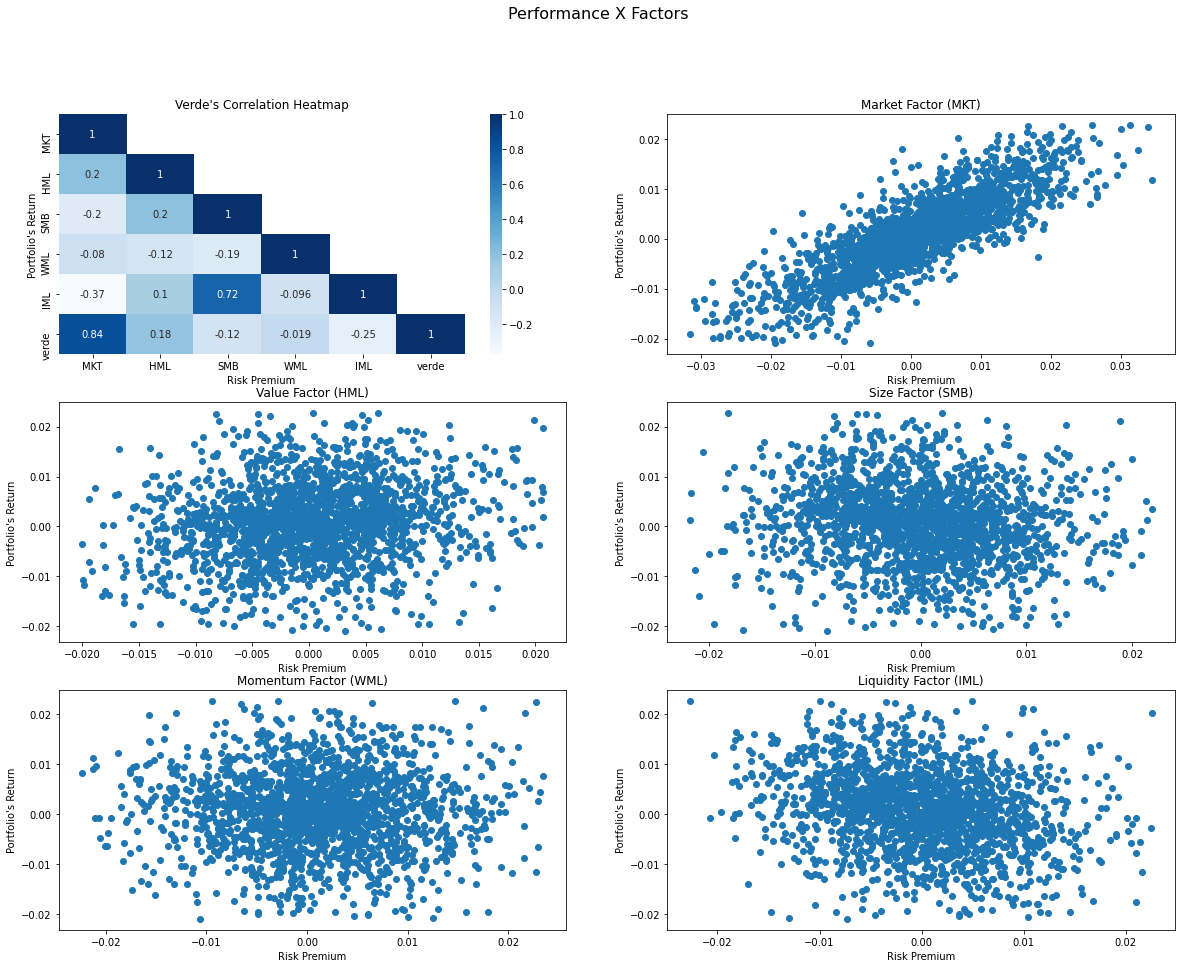

In [ ]:
corr = risk_factors_treated[factors+["verde"]].corr(method="pearson")
corr = corr.mask(np.invert(np.tril(np.ones(corr.shape)).astype(np.bool)))

fig, ax = plt.subplots(3,2,  figsize=(20,15))

fig.suptitle("Performance X Factors", size=16)

ax[0,0].set_title("Verde's Correlation Heatmap")
sns.heatmap(corr, ax=ax[0,0], annot=True, cmap=sns.color_palette("Blues", as_cmap=True))

ax[0,1].set_title("Market Factor (MKT)")
ax[0,1].scatter(risk_factors_treated["MKT"], risk_factors_treated["verde"],zorder=0, label="Market Factor Values")

ax[1,0].scatter(risk_factors_treated["HML"], risk_factors_treated["verde"], zorder=0, label="Value Factor Values")
ax[1,0].set_title("Value Factor (HML)")

ax[1,1].scatter(risk_factors_treated["SMB"], risk_factors_treated["verde"], zorder=0, label="Size Factor Values")
ax[1,1].set_title("Size Factor (SMB)")

ax[2,0].scatter(risk_factors_treated["WML"], risk_factors_treated["verde"], zorder=0, label="Momentum Factor Values")
ax[2,0].set_title("Momentum Factor (WML)")

ax[2,1].scatter(risk_factors_treated["IML"], risk_factors_treated["verde"], zorder=0, label="Liquidity Factor Values")
ax[2,1].set_title("Liquidity Factor (IML)")

for i in range(3):
    for j in range(2):
        ax[i,j].set_xlabel("Risk Premium")
        ax[i,j].set_ylabel("Portfolio's Return")

plt.show()

####Alaska Black


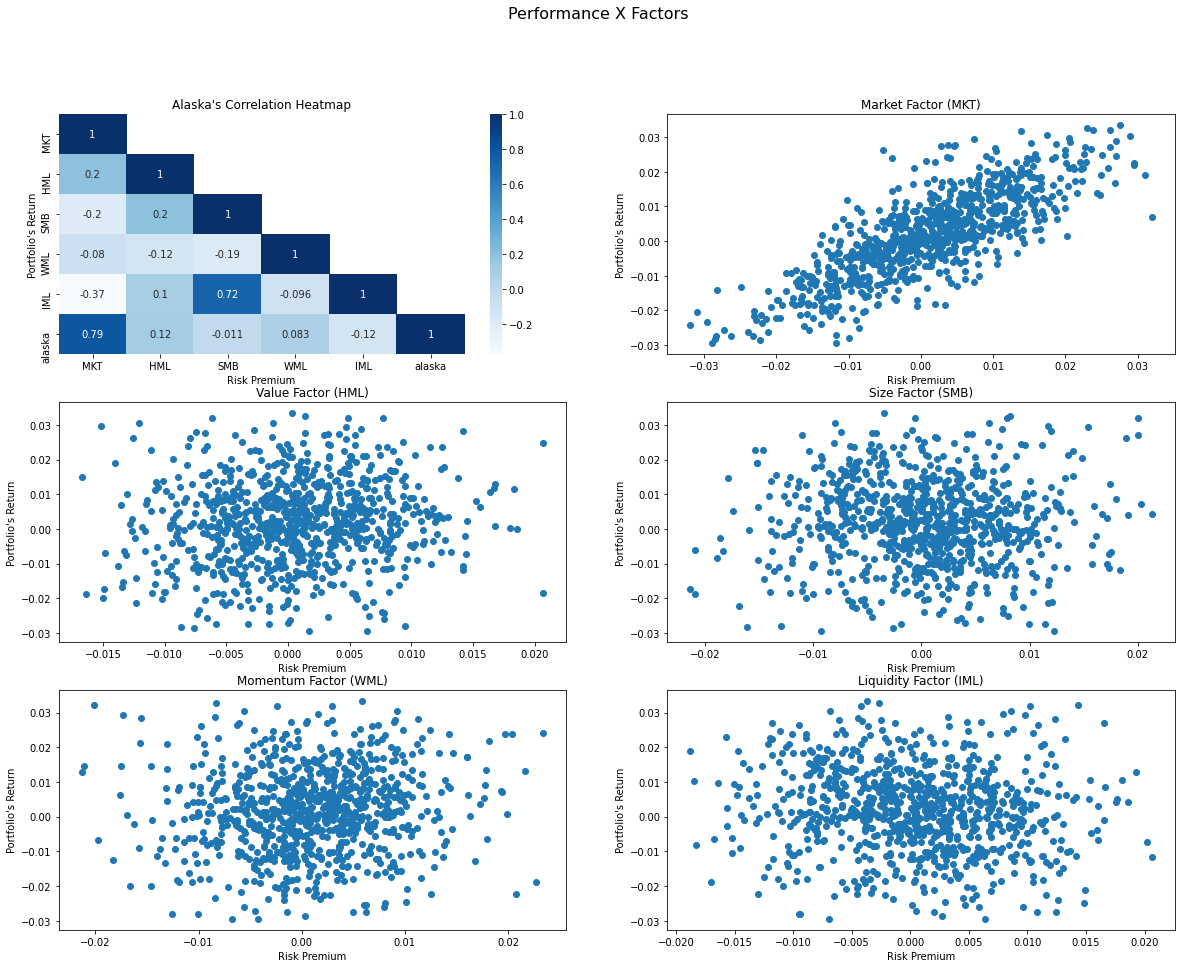

In [ ]:
corr = risk_factors_treated[factors+["alaska"]].corr(method="pearson")
corr = corr.mask(np.invert(np.tril(np.ones(corr.shape)).astype(np.bool)))

fig, ax = plt.subplots(3,2,  figsize=(20,15))

fig.suptitle("Performance X Factors", size=16)

ax[0,0].set_title("Alaska's Correlation Heatmap")
sns.heatmap(corr, ax=ax[0,0], annot=True, cmap=sns.color_palette("Blues", as_cmap=True))

ax[0,1].set_title("Market Factor (MKT)")
ax[0,1].scatter(risk_factors_treated["MKT"], risk_factors_treated["alaska"])

ax[1,0].scatter(risk_factors_treated["HML"], risk_factors_treated["alaska"])
ax[1,0].set_title("Value Factor (HML)")

ax[1,1].scatter(risk_factors_treated["SMB"], risk_factors_treated["alaska"])
ax[1,1].set_title("Size Factor (SMB)")

ax[2,0].scatter(risk_factors_treated["WML"], risk_factors_treated["alaska"])
ax[2,0].set_title("Momentum Factor (WML)")

ax[2,1].scatter(risk_factors_treated["IML"], risk_factors_treated["alaska"])
ax[2,1].set_title("Liquidity Factor (IML)")


for i in range(3):
    for j in range(2):
        ax[i,j].set_xlabel("Risk Premium")
        ax[i,j].set_ylabel("Portfolio's Return")

plt.show()

####Avantgarde


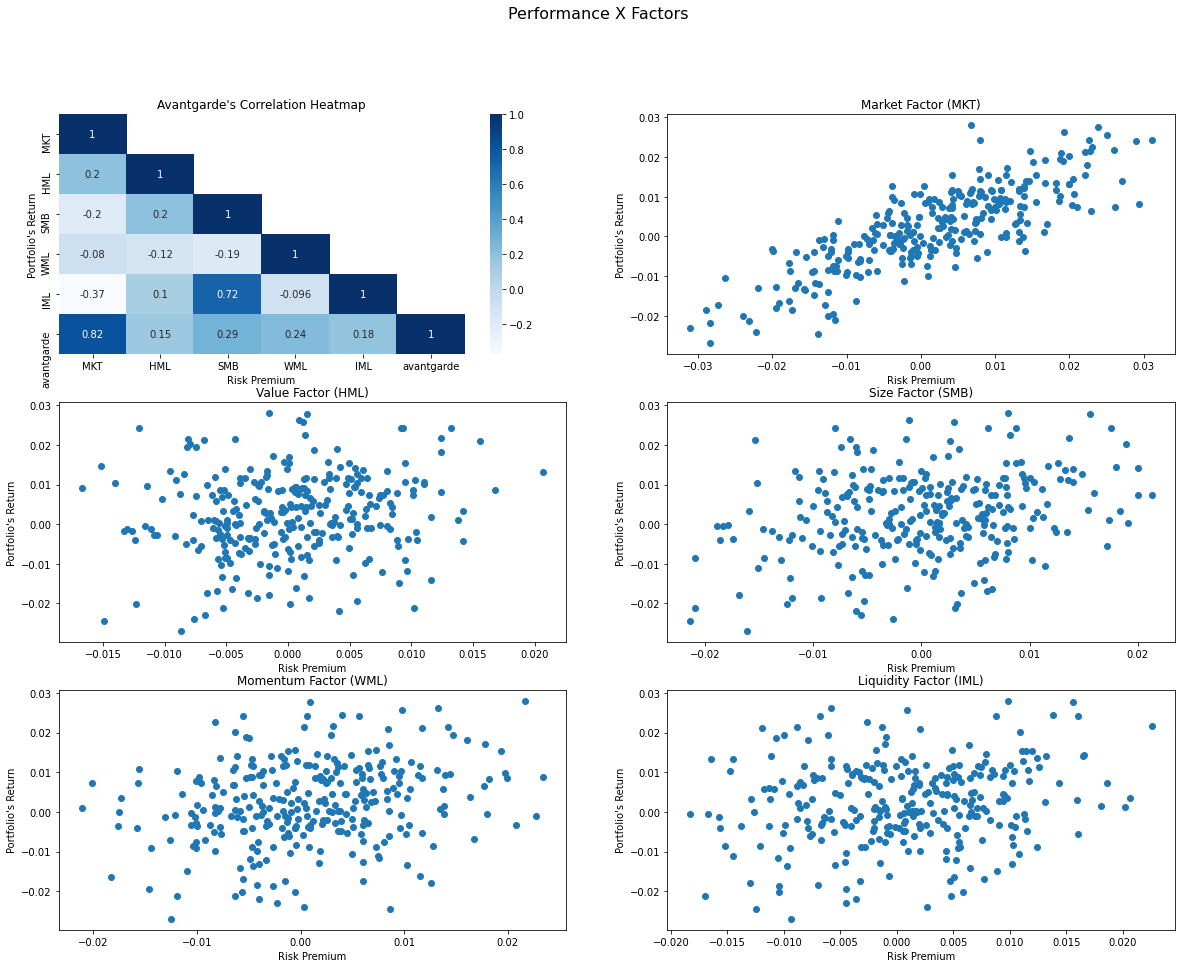

In [ ]:
corr = risk_factors_treated[factors+["avantgarde"]].corr(method="pearson")
corr = corr.mask(np.invert(np.tril(np.ones(corr.shape)).astype(np.bool)))

fig, ax = plt.subplots(3,2,  figsize=(20,15))

fig.suptitle("Performance X Factors", size=16)

ax[0,0].set_title("Avantgarde's Correlation Heatmap")
sns.heatmap(corr, ax=ax[0,0], annot=True, cmap=sns.color_palette("Blues", as_cmap=True))



ax[0,1].set_title("Market Factor (MKT)")
ax[0,1].scatter(risk_factors_treated["MKT"], risk_factors_treated["avantgarde"],zorder=0, label="Market Factor Values")

ax[1,0].scatter(risk_factors_treated["HML"], risk_factors_treated["avantgarde"], zorder=0, label="Value Factor Values")
ax[1,0].set_title("Value Factor (HML)")

ax[1,1].scatter(risk_factors_treated["SMB"], risk_factors_treated["avantgarde"], zorder=0, label="Size Factor Values")
ax[1,1].set_title("Size Factor (SMB)")

ax[2,0].scatter(risk_factors_treated["WML"], risk_factors_treated["avantgarde"], zorder=0, label="Momentum Factor Values")
ax[2,0].set_title("Momentum Factor (WML)")

ax[2,1].scatter(risk_factors_treated["IML"], risk_factors_treated["avantgarde"], zorder=0, label="Liquidity Factor Values")
ax[2,1].set_title("Liquidity Factor (IML)")

for i in range(3):
    for j in range(2):
        ax[i,j].set_xlabel("Risk Premium")
        ax[i,j].set_ylabel("Portfolio's Return")

plt.show()

####Constellation


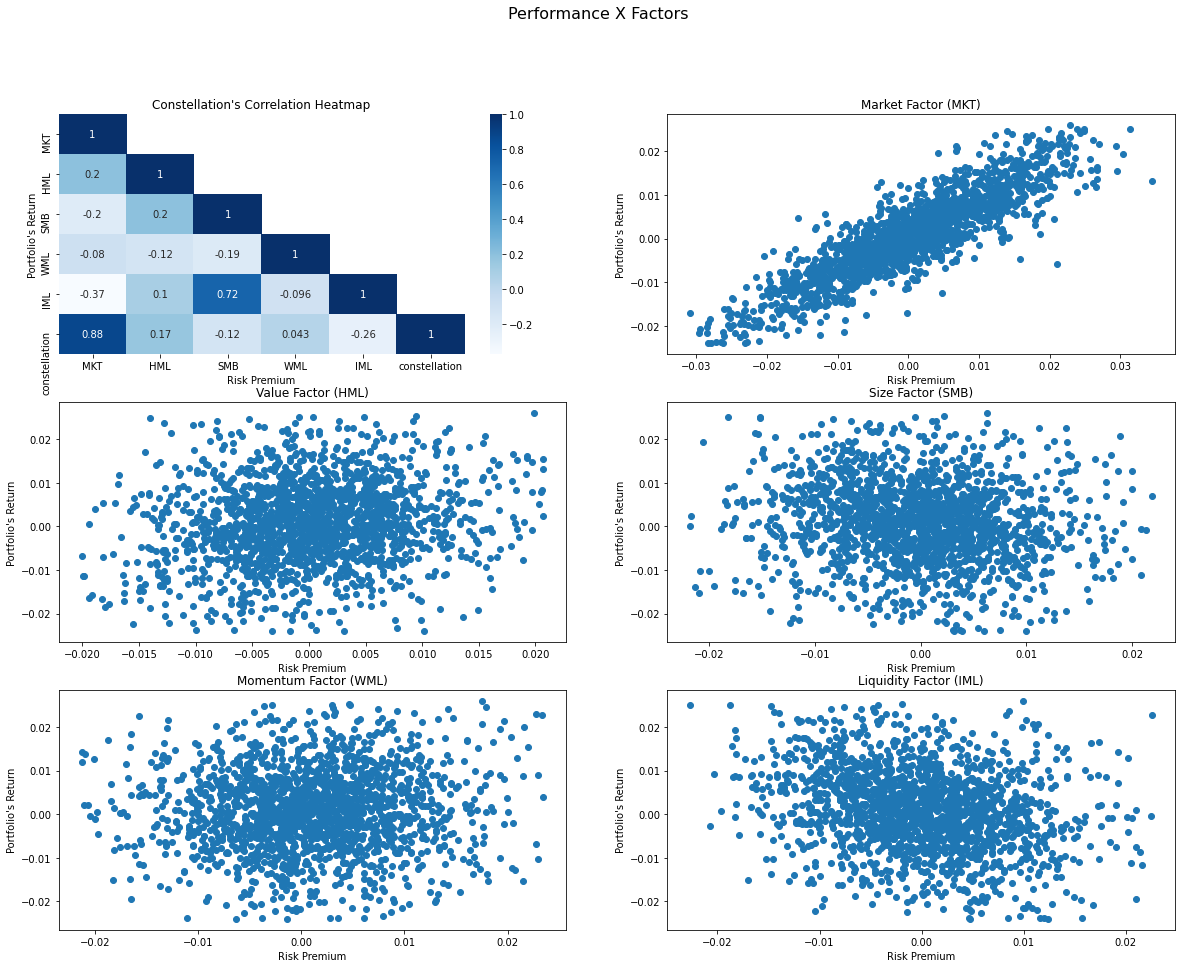

In [ ]:
corr = risk_factors_treated[factors+["constellation"]].corr(method="pearson")
corr = corr.mask(np.invert(np.tril(np.ones(corr.shape)).astype(np.bool)))

fig, ax = plt.subplots(3,2,  figsize=(20,15))

fig.suptitle("Performance X Factors", size=16)

ax[0,0].set_title("Constellation's Correlation Heatmap")
sns.heatmap(corr, ax=ax[0,0], annot=True, cmap=sns.color_palette("Blues", as_cmap=True))

ax[0,1].set_title("Market Factor (MKT)")
ax[0,1].scatter(risk_factors_treated["MKT"], risk_factors_treated["constellation"],zorder=0, label="Market Factor Values")

ax[1,0].scatter(risk_factors_treated["HML"], risk_factors_treated["constellation"], zorder=0, label="Value Factor Values")
ax[1,0].set_title("Value Factor (HML)")

ax[1,1].scatter(risk_factors_treated["SMB"], risk_factors_treated["constellation"], zorder=0, label="Size Factor Values")
ax[1,1].set_title("Size Factor (SMB)")

ax[2,0].scatter(risk_factors_treated["WML"], risk_factors_treated["constellation"], zorder=0, label="Momentum Factor Values")
ax[2,0].set_title("Momentum Factor (WML)")

ax[2,1].scatter(risk_factors_treated["IML"], risk_factors_treated["constellation"], zorder=0, label="Liquidity Factor Values")
ax[2,1].set_title("Liquidity Factor (IML)")

for i in range(3):
    for j in range(2):
        ax[i,j].set_xlabel("Risk Premium")
        ax[i,j].set_ylabel("Portfolio's Return")

plt.show()

####Cosmos


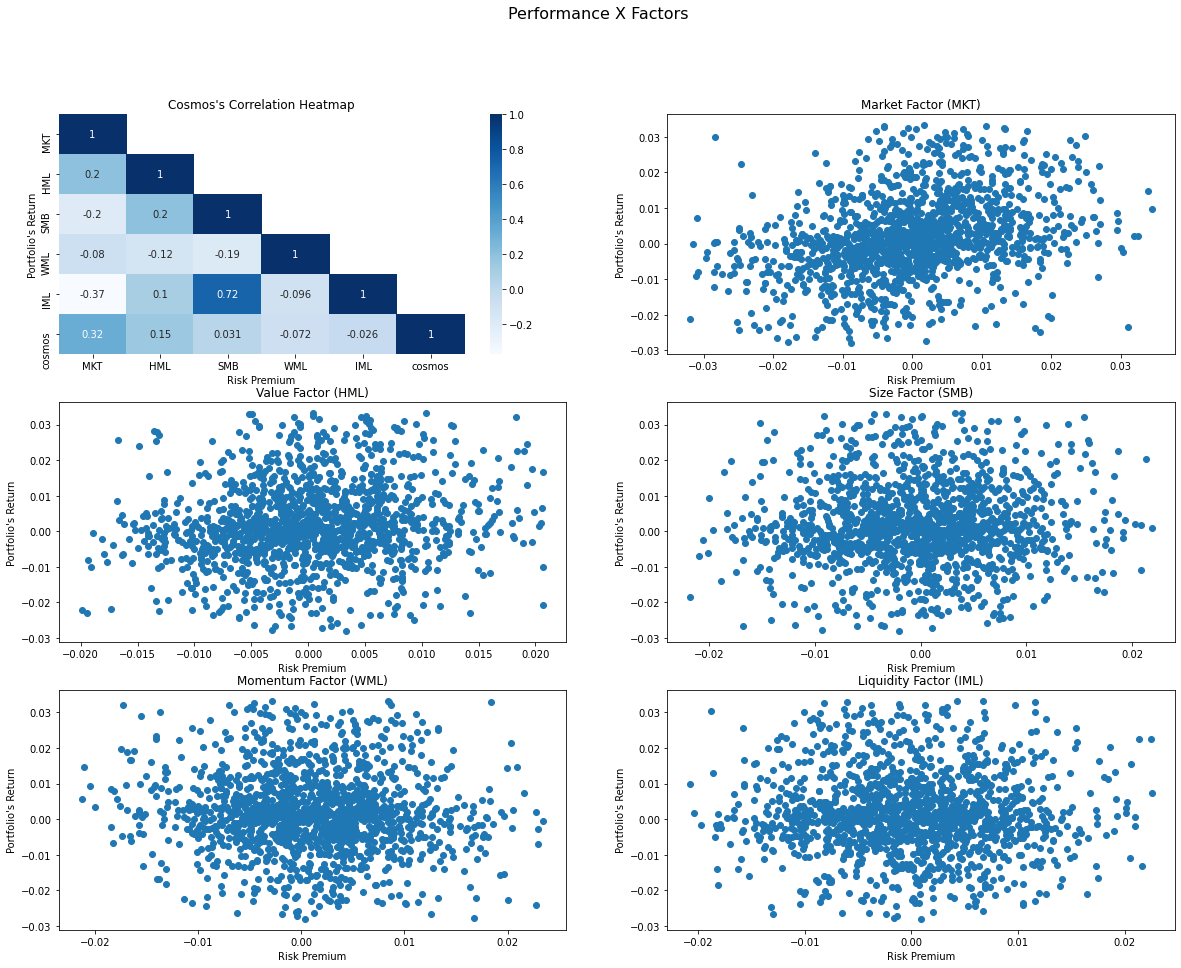

In [ ]:
corr = risk_factors_treated[factors+["cosmos"]].corr(method="pearson")
corr = corr.mask(np.invert(np.tril(np.ones(corr.shape)).astype(np.bool)))

fig, ax = plt.subplots(3,2,  figsize=(20,15))

fig.suptitle("Performance X Factors", size=16)

ax[0,0].set_title("Cosmos's Correlation Heatmap")
sns.heatmap(corr, ax=ax[0,0], annot=True, cmap=sns.color_palette("Blues", as_cmap=True))

ax[0,1].set_title("Market Factor (MKT)")
ax[0,1].scatter(risk_factors_treated["MKT"], risk_factors_treated["cosmos"],zorder=0, label="Market Factor Values")

ax[1,0].scatter(risk_factors_treated["HML"], risk_factors_treated["cosmos"], zorder=0, label="Value Factor Values")
ax[1,0].set_title("Value Factor (HML)")

ax[1,1].scatter(risk_factors_treated["SMB"], risk_factors_treated["cosmos"], zorder=0, label="Size Factor Values")
ax[1,1].set_title("Size Factor (SMB)")

ax[2,0].scatter(risk_factors_treated["WML"], risk_factors_treated["cosmos"], zorder=0, label="Momentum Factor Values")
ax[2,0].set_title("Momentum Factor (WML)")

ax[2,1].scatter(risk_factors_treated["IML"], risk_factors_treated["cosmos"], zorder=0, label="Liquidity Factor Values")
ax[2,1].set_title("Liquidity Factor (IML)")


for i in range(3):
    for j in range(2):
        ax[i,j].set_xlabel("Risk Premium")
        ax[i,j].set_ylabel("Portfolio's Return")
plt.show()

####Dynamo

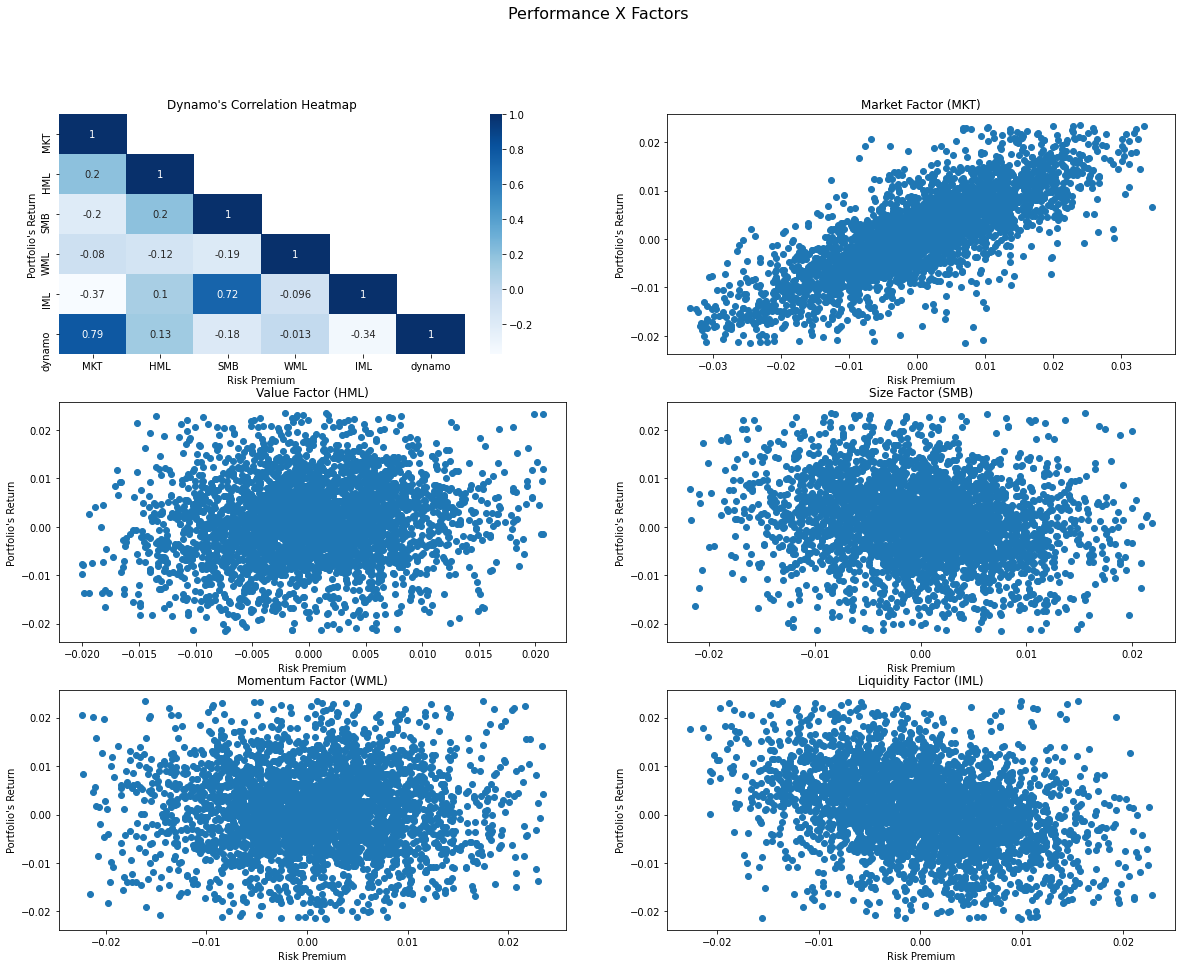

In [ ]:
corr = risk_factors_treated[factors+["dynamo"]].corr(method="pearson")
corr = corr.mask(np.invert(np.tril(np.ones(corr.shape)).astype(np.bool)))

fig, ax = plt.subplots(3,2,  figsize=(20,15))

fig.suptitle("Performance X Factors", size=16)

ax[0,0].set_title("Dynamo's Correlation Heatmap")
sns.heatmap(corr, ax=ax[0,0], annot=True, cmap=sns.color_palette("Blues", as_cmap=True))

ax[0,1].set_title("Market Factor (MKT)")
ax[0,1].scatter(risk_factors_treated["MKT"], risk_factors_treated["dynamo"],zorder=0, label="Market Factor Values")

ax[1,0].scatter(risk_factors_treated["HML"], risk_factors_treated["dynamo"], zorder=0, label="Value Factor Values")
ax[1,0].set_title("Value Factor (HML)")

ax[1,1].scatter(risk_factors_treated["SMB"], risk_factors_treated["dynamo"], zorder=0, label="Size Factor Values")
ax[1,1].set_title("Size Factor (SMB)")

ax[2,0].scatter(risk_factors_treated["WML"], risk_factors_treated["dynamo"], zorder=0, label="Momentum Factor Values")
ax[2,0].set_title("Momentum Factor (WML)")

ax[2,1].scatter(risk_factors_treated["IML"], risk_factors_treated["dynamo"], zorder=0, label="Liquidity Factor Values")
ax[2,1].set_title("Liquidity Factor (IML)")


for i in range(3):
    for j in range(2):
        ax[i,j].set_xlabel("Risk Premium")
        ax[i,j].set_ylabel("Portfolio's Return")
plt.show()

####Real Investor

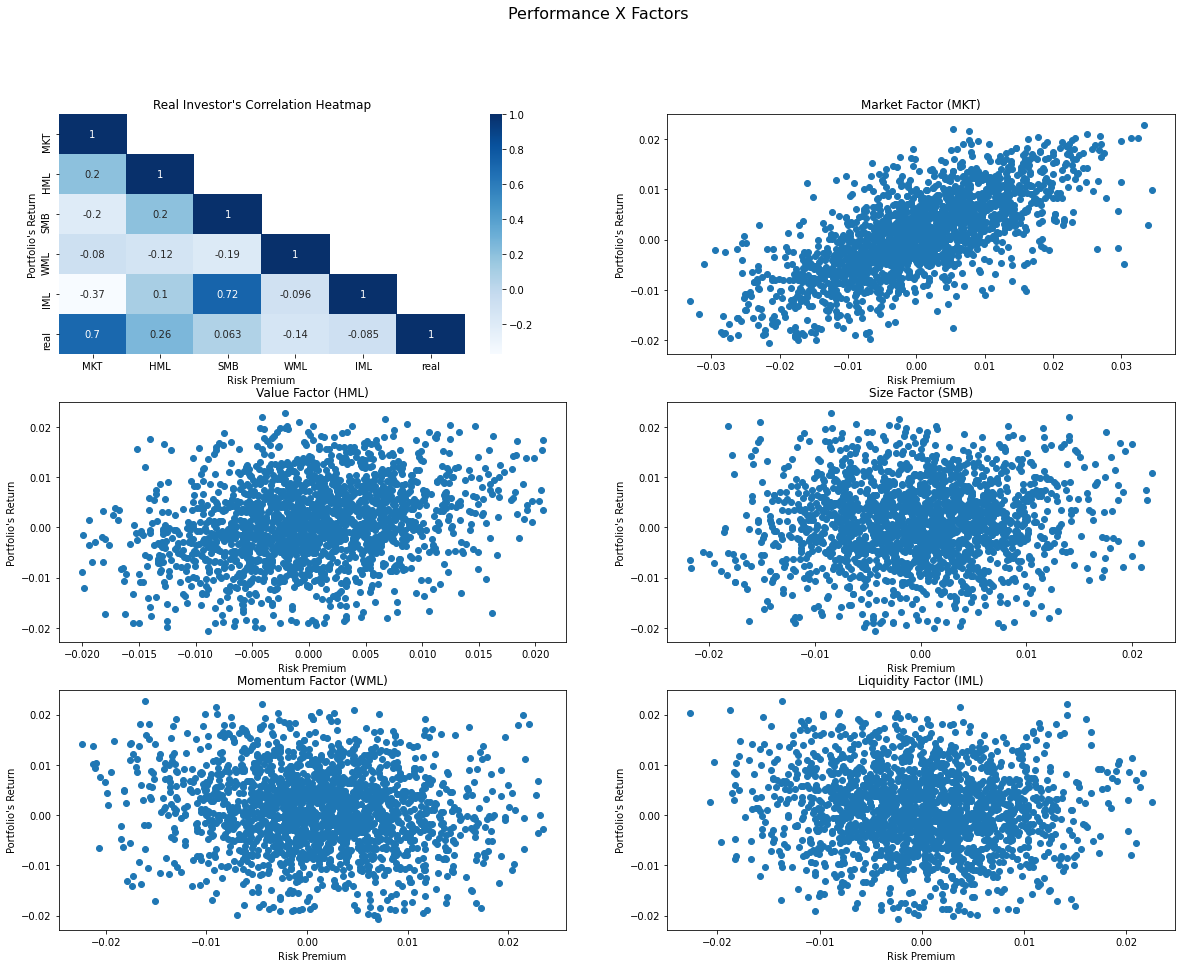

In [ ]:
corr = risk_factors_treated[factors+["real"]].corr(method="pearson")
corr = corr.mask(np.invert(np.tril(np.ones(corr.shape)).astype(np.bool)))

fig, ax = plt.subplots(3,2,  figsize=(20,15))

fig.suptitle("Performance X Factors", size=16)

ax[0,0].set_title("Real Investor's Correlation Heatmap")
sns.heatmap(corr, ax=ax[0,0], annot=True, cmap=sns.color_palette("Blues", as_cmap=True))

ax[0,1].set_title("Market Factor (MKT)")
ax[0,1].scatter(risk_factors_treated["MKT"], risk_factors_treated["real"],zorder=0, label="Market Factor Values")

ax[1,0].scatter(risk_factors_treated["HML"], risk_factors_treated["real"], zorder=0, label="Value Factor Values")
ax[1,0].set_title("Value Factor (HML)")

ax[1,1].scatter(risk_factors_treated["SMB"], risk_factors_treated["real"], zorder=0, label="Size Factor Values")
ax[1,1].set_title("Size Factor (SMB)")

ax[2,0].scatter(risk_factors_treated["WML"], risk_factors_treated["real"], zorder=0, label="Momentum Factor Values")
ax[2,0].set_title("Momentum Factor (WML)")

ax[2,1].scatter(risk_factors_treated["IML"], risk_factors_treated["real"], zorder=0, label="Liquidity Factor Values")
ax[2,1].set_title("Liquidity Factor (IML)")


for i in range(3):
    for j in range(2):
        ax[i,j].set_xlabel("Risk Premium")
        ax[i,j].set_ylabel("Portfolio's Return")
plt.show()

As we can observe in all graphics within this section, all funds' portfolios have clear strong and positive correlations with the market risk factor, which is not observed with the rest of the factors.

##Applying 5-factor CAPM

In [ ]:
risk_factors_treated.tail(1)

,MKT,HML,SMB,WML,IML,verde,alaska,avantgarde,constellation,cosmos,dynamo,real
2020-12-29,0.002851,0.001345,0.006832,-0.00053,0.005666,0.004036,0.004182,0.007445,0.001025,-0.000124,0.001892,0.00238


In [ ]:
funds = ["verde","alaska","avantgarde","constellation","cosmos","dynamo","real"]
factors = ["MKT","HML","SMB","WML","IML"]

In [ ]:
CAPM_results = dict()
for fund in funds:
    df = risk_factors_treated[factors+[fund]].copy()
    df.dropna(inplace=True)

    X = sm.add_constant(df[factors])
    X["alpha"] = X["const"]
    X.drop(columns="const", inplace=True)
    y = df[[fund]]

    capm = sm.OLS(y, X).fit()
    CAPM_results[fund] = capm
    print(str(y.columns[0]).upper())
    print(capm.summary2())
    print("≡"*100 + "\n")

VERDE
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.723      
Dependent Variable: verde            AIC:                -15448.0344
Date:               2021-02-10 18:31 BIC:                -15414.7241
No. Observations:   1904             Log-Likelihood:     7730.0     
Df Model:           5                F-statistic:        993.5      
Df Residuals:       1898             Prob (F-statistic): 0.00       
R-squared:          0.724            Scale:              1.7479e-05 
-----------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|      [0.025     0.975]
-----------------------------------------------------------------------
MKT       0.6854      0.0107    64.3097    0.0000     0.6645     0.7063
HML      -0.1389      0.0156    -8.9064    0.0000    -0.1695    -0.1083
SMB       0.1202      0.0256     4.6896    0.0000     0.0699     0.1705
WML       0.0920      0.0133 

Rewriting the summaries above:

In [ ]:
def get_regression_statistics(model):
    params = pd.Series(model.params.tolist(), index=[x+"_beta" if x != "alpha" else x for x in model.params.index])
    tvalues = pd.Series(model.tvalues.tolist(), index=[x+"_tvalue" for x in model.tvalues.index])
    pvalues = pd.Series(model.pvalues.tolist(), index=[x+"_pvalue" for x in model.pvalues.index])
    fvalue = pd.Series([model.fvalue], index=["fvalue"])
    fpvalue = pd.Series([model.f_pvalue], index=["fpvalue"])
    rsquared_adj = pd.Series([model.rsquared_adj], index=["rsquared_adj"])
    return params.append(tvalues).append(pvalues).append(fvalue).append(fpvalue).append(rsquared_adj)

In [ ]:
def get_all_regression_statistics(models):
    regression_statistics = pd.DataFrame(columns=["fund","MKT_beta","HML_beta","SMB_beta","WML_beta","IML_beta","alpha","MKT_tvalue","HML_tvalue","SMB_tvalue","WML_tvalue","IML_tvalue","alpha_tvalue","MKT_pvalue","HML_pvalue","SMB_pvalue","WML_pvalue","IML_pvalue","alpha_pvalue","fvalue"  ,"fpvalue" ,"rsquared_adj"])
    for model in models:
        regression_statistics.loc[model] = get_regression_statistics(models[model])
    return regression_statistics

In [ ]:
CAPM_statistics = get_all_regression_statistics(CAPM_results)

###Comparing Betas

####Market Factor

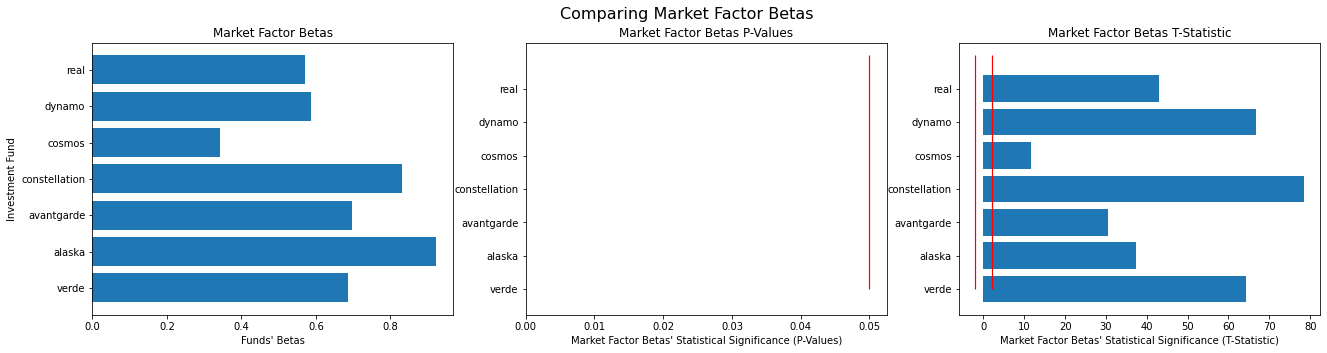

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(22,5))
fig.suptitle("Comparing Market Factor Betas", size=16)

ax[0].barh(y=CAPM_statistics["MKT_beta"].index, width= CAPM_statistics["MKT_beta"])
ax[0].set_title("Market Factor Betas")
ax[0].set_xlabel("Funds' Betas")
ax[0].set_ylabel("Investment Fund")


ax[1].barh(y=CAPM_statistics["MKT_pvalue"].index, width=CAPM_statistics["MKT_pvalue"])
ax[1].vlines(x=0.05, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[1].set_title("Market Factor Betas P-Values")
ax[1].set_xlabel("Market Factor Betas' Statistical Significance (P-Values)")


ax[2].barh(y=CAPM_statistics["MKT_tvalue"].index, width=CAPM_statistics["MKT_tvalue"])
ax[2].vlines(x=2, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[2].vlines(x=-2, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[2].set_title("Market Factor Betas T-Statistic")
ax[2].set_xlabel("Market Factor Betas' Statistical Significance (T-Statistic)")


plt.show()

- All MKT betas are positives and significant as expected. 

####Value Factor

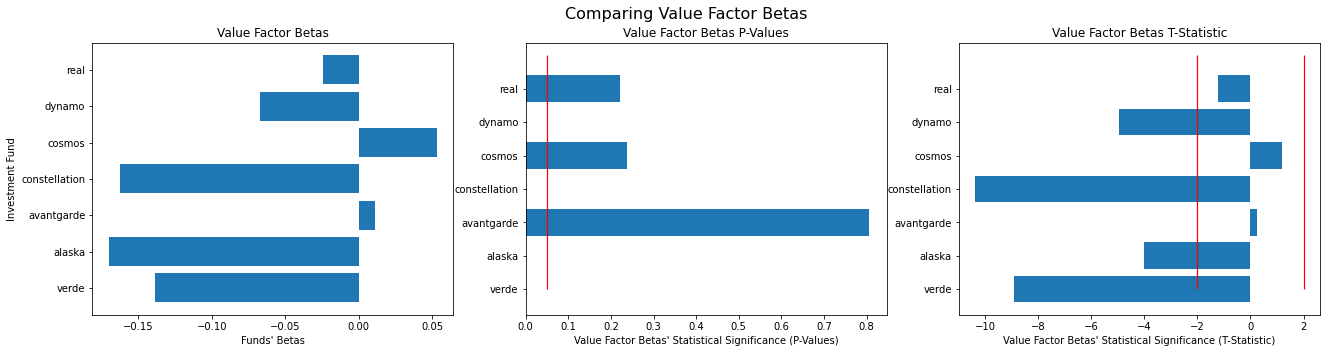

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(22,5))
fig.suptitle("Comparing Value Factor Betas", size=16)

ax[0].barh(y=CAPM_statistics["HML_beta"].index, width=[x for x in CAPM_statistics["HML_beta"]])
ax[0].set_title("Value Factor Betas")
ax[0].set_xlabel("Funds' Betas")
ax[0].set_ylabel("Investment Fund")


ax[1].barh(y=CAPM_statistics["HML_pvalue"].index, width=[x for x in CAPM_statistics["HML_pvalue"]])
ax[1].vlines(x=0.05, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[1].set_title("Value Factor Betas P-Values")
ax[1].set_xlabel("Value Factor Betas' Statistical Significance (P-Values)")


ax[2].barh(y=CAPM_statistics["HML_tvalue"].index, width=[x for x in CAPM_statistics["HML_tvalue"]])
ax[2].vlines(x=2, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[2].vlines(x=-2, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[2].set_title("Value Factor Betas T-Statistic")
ax[2].set_xlabel("Value Factor Betas' Statistical Significance (T-Statistic)")


plt.show()

- Dynamo, Constellation, Alaska and Verde's betas are negative and significant
- Real Investor, Cosmos and AvantGarde's betas are non-significant

####Size Factor

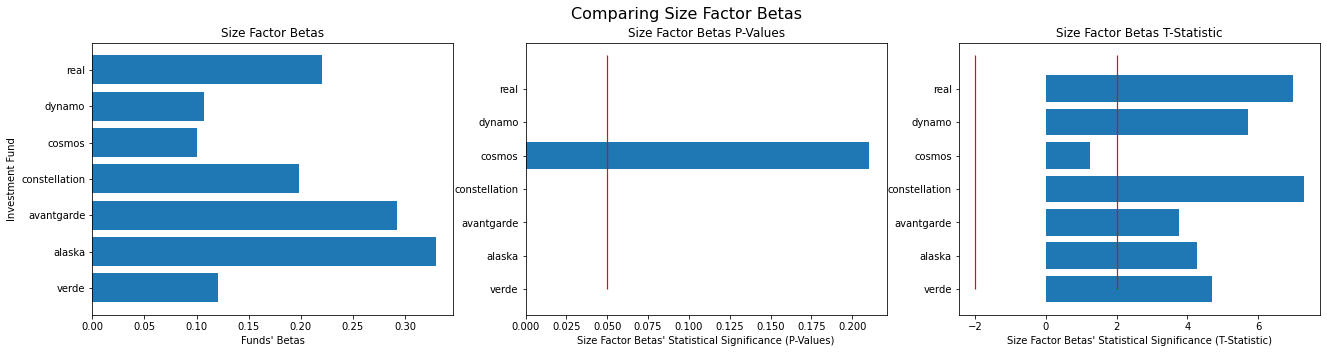

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(22,5))
fig.suptitle("Comparing Size Factor Betas", size=16)

ax[0].barh(y=CAPM_statistics["SMB_beta"].index, width=[x for x in CAPM_statistics["SMB_beta"]])
ax[0].set_title("Size Factor Betas")
ax[0].set_xlabel("Funds' Betas")
ax[0].set_ylabel("Investment Fund")


ax[1].barh(y=CAPM_statistics["SMB_pvalue"].index, width=[x for x in CAPM_statistics["SMB_pvalue"]])
ax[1].vlines(x=0.05, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[1].set_title("Size Factor Betas P-Values")
ax[1].set_xlabel("Size Factor Betas' Statistical Significance (P-Values)")


ax[2].barh(y=CAPM_statistics["SMB_tvalue"].index, width=[x for x in CAPM_statistics["SMB_tvalue"]])
ax[2].vlines(x=2, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[2].vlines(x=-2, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[2].set_title("Size Factor Betas T-Statistic")
ax[2].set_xlabel("Size Factor Betas' Statistical Significance (T-Statistic)")


plt.show()

- All betas are positive and significant, except for Cosmos, which is non-significant.

####Liquidity Factor

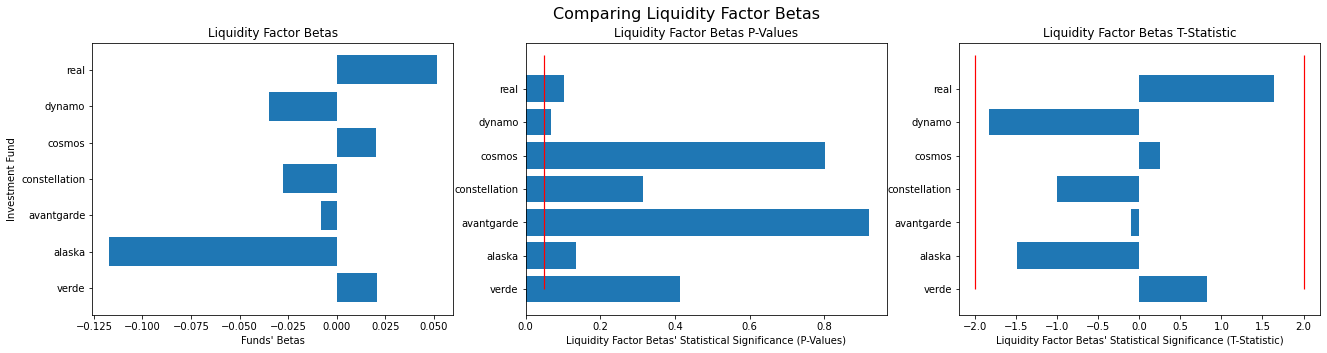

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(22,5))
fig.suptitle("Comparing Liquidity Factor Betas", size=16)

ax[0].barh(y=CAPM_statistics["IML_beta"].index, width=[x for x in CAPM_statistics["IML_beta"]])
ax[0].set_title("Liquidity Factor Betas")
ax[0].set_xlabel("Funds' Betas")
ax[0].set_ylabel("Investment Fund")


ax[1].barh(y=CAPM_statistics["IML_pvalue"].index, width=[x for x in CAPM_statistics["IML_pvalue"]])
ax[1].vlines(x=0.05, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[1].set_title("Liquidity Factor Betas P-Values")
ax[1].set_xlabel("Liquidity Factor Betas' Statistical Significance (P-Values)")


ax[2].barh(y=CAPM_statistics["IML_tvalue"].index, width=[x for x in CAPM_statistics["IML_tvalue"]])
ax[2].vlines(x=2, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[2].vlines(x=-2, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[2].set_title("Liquidity Factor Betas T-Statistic")
ax[2].set_xlabel("Liquidity Factor Betas' Statistical Significance (T-Statistic)")


plt.show()

- There are no significant Liquidity Factor betas 

####Momentum Factor

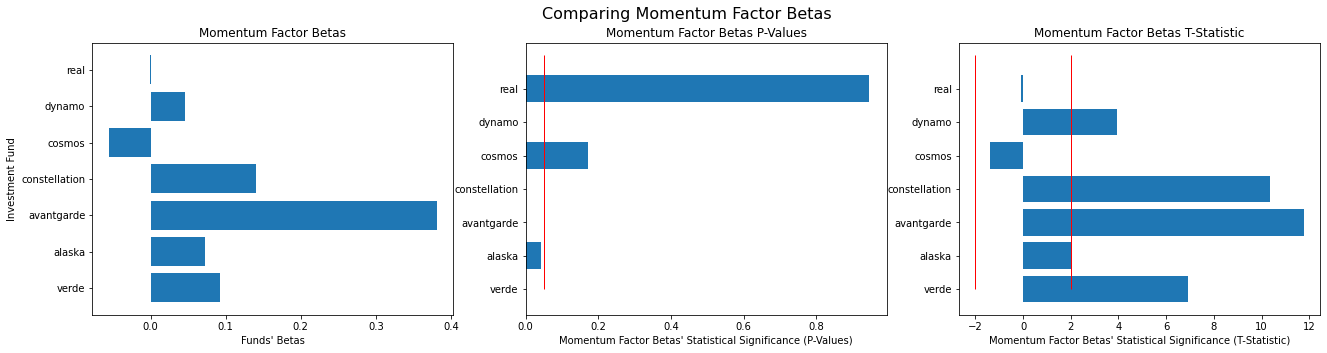

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(22,5))
fig.suptitle("Comparing Momentum Factor Betas", size=16)

ax[0].barh(y=CAPM_statistics["WML_beta"].index, width=[x for x in CAPM_statistics["WML_beta"]])
ax[0].set_title("Momentum Factor Betas")
ax[0].set_xlabel("Funds' Betas")
ax[0].set_ylabel("Investment Fund")


ax[1].barh(y=CAPM_statistics["WML_pvalue"].index, width=[x for x in CAPM_statistics["WML_pvalue"]])
ax[1].vlines(x=0.05, ymin=0, ymax=7, color="red", linewidth=1)
ax[1].set_title("Momentum Factor Betas P-Values")
ax[1].set_xlabel("Momentum Factor Betas' Statistical Significance (P-Values)")


ax[2].barh(y=CAPM_statistics["WML_tvalue"].index, width=[x for x in CAPM_statistics["WML_tvalue"]])
ax[2].vlines(x=2, ymin=0, ymax=7, color="red", linewidth=1)
ax[2].vlines(x=-2, ymin=0, ymax=7, color="red", linewidth=1)
ax[2].set_title("Momentum Factor Betas T-Statistic")
ax[2].set_xlabel("Momentum Factor Betas' Statistical Significance (T-Statistic)")


plt.show()

- All betas are positive and significant, except for Cosmos and Real Investor, which are non-significant. 

###Comparing Alphas

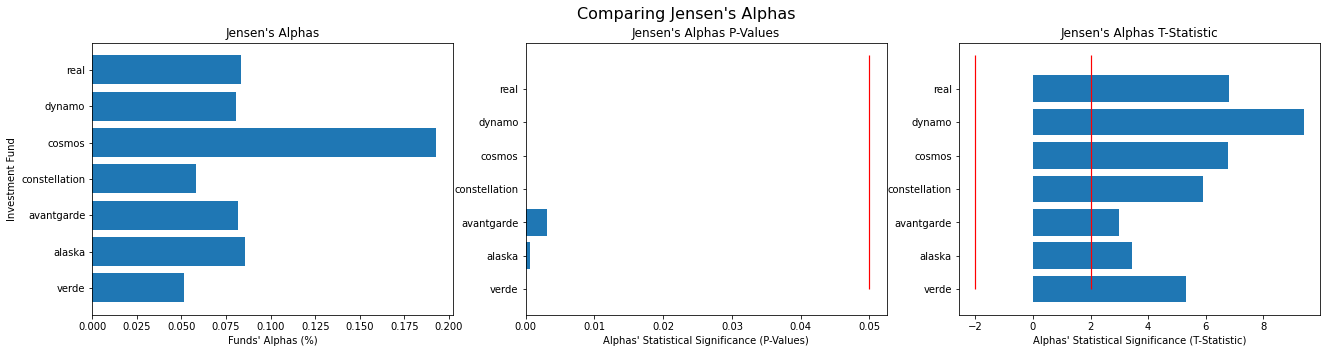

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(22,5))
fig.suptitle("Comparing Jensen's Alphas", size=16)

ax[0].barh(y=CAPM_statistics["alpha"].index, width=[x*100 for x in CAPM_statistics["alpha"]])
ax[0].set_title("Jensen's Alphas")
ax[0].set_xlabel("Funds' Alphas (%)")
ax[0].set_ylabel("Investment Fund")


ax[1].barh(y=CAPM_statistics["alpha_pvalue"].index, width=[x for x in CAPM_statistics["alpha_pvalue"]])
ax[1].vlines(x=0.05, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[1].set_title("Jensen's Alphas P-Values")
ax[1].set_xlabel("Alphas' Statistical Significance (P-Values)")

ax[2].barh(y=CAPM_statistics["alpha_tvalue"].index, width=[x for x in CAPM_statistics["alpha_tvalue"]])
ax[2].vlines(x=2, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[2].vlines(x=-2, ymin=0, ymax=7, color="red", linewidth=1.2)
ax[2].set_title("Jensen's Alphas T-Statistic")
ax[2].set_xlabel("Alphas' Statistical Significance (T-Statistic)")


plt.show()

#Conclusion

- All selected funds generate significant alpha, highlighting Cosmos fund, which generates ~0,2% of alpha per day. It means that their managers have proper competence to manager a fund.

#References

JENSEN, M. C. The performance of mutual funds in the period 1945-1964. The Journal
of finance, JSTOR, v. 23, n. 2, p. 389–416, 1968.

SHARPE, W. F. Capital asset prices: A theory of market equilibrium under conditions of
risk. The journal of finance, Wiley Online Library, v. 19, n. 3, p. 425–442, 1964.

TREYNOR, J. L. Jack treynor’s’ toward a theory of market value of risky assets’.
Available at SSRN 628187, 1962.

LINTNER, J. Security prices, risk, and maximal gains from diversification. The journal of
finance, JSTOR, v. 20, n. 4, p. 587–615, 1965.

FAMA, E. F.; FRENCH, K. R. Common risk factors in the returns on stocks and bonds.
Journal of Financial Economics, 1993.

LIU, W. A liquidity-augmented capital asset pricing model. Journal of Financial
Economics, Elsevier, v. 82, n. 3, p. 631–671, 2006.

Link to this notebook: [here](http://bit.ly/jensens-alpha)

Developed by [Vítor Diniz](https://www.linkedin.com/in/vitorbdiniz/)